# Toy Experiments

In [1]:
import os, sys
sys.path.append("..")

from src import distributions
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from basic import ScoreNetwork

import numpy as np

from matplotlib import pyplot as plt

from tqdm import tqdm
from IPython.display import clear_output

from src.plotters import plot_results

from src.plotters import plot_trajectories

import os
SEED = 0xBADBEEF
torch.manual_seed(SEED); np.random.seed(SEED)

In [2]:
X_sampler = distributions.StandardNormalSampler(dim=2, device="cuda")
Y_sampler = distributions.SwissRollSampler(device="cuda")

DIM = 2
H = 100

batch_size = 1000
lr = 1e-4
n_steps = 100
GAMMA = 0.0
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 5000


ZC = 1
Z_STD = 1.0

In [3]:
def trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=500):

    G_mse = []
    G_var = []
    sde_mse = []
    sde_var = []
    
    for step in tqdm(range(MAX_STEPS)):
            
        for G_iter in range(G_ITERS):

            for f_iter in range(f_ITERS):
                x0 = X_sampler.sample(batch_size)
                Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
                xN = G(torch.cat([x0, Z], axis = -1))
                
                t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
                xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
                
                f_loss = ((sde.shift_model(xt, t) - (xN - xt)/(1-t)) ** 2).mean()
                sde_opt.zero_grad(); f_loss.backward(); sde_opt.step()

            x0 = X_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))

            t = (torch.rand(x0.shape[0])[:, None]*0.99).cuda()
            xt = x0 + (xN - x0) * t + torch.randn_like(x0)*torch.sqrt(t*(1-t)*GAMMA)
            
            f_x_t = sde.shift_model(xt, t)
            E = (xN - xt)/(1-t)

            loss1 = ((f_x_t*E).mean() - (f_x_t*f_x_t).mean()/2)*2
            loss2 = - D(xN).mean()

            G_loss = loss1 + loss2
            
            G_opt.zero_grad(); G_loss.backward(); G_opt.step()

        print(loss1.item(), loss2.item())
        
        
        # plotter 1
        if step % 500 == 0:
            clear_output(wait=True)
            
            # fig, axes = plot_trajectories(X_sampler, G, ZC, Z_STD, sde, k=10)
            # plt.show()
            
            original_dataset = torch.cat(
                [X_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            target_dataset = torch.cat(
                [Y_sampler.sample(batch_size) for i in range(plot_n_samples//batch_size + 1)],
                dim=0,
            )[:plot_n_samples].cpu()
            
            X = X_sampler.sample(plot_n_samples)
            
            Z = torch.randn(plot_n_samples, ZC, device='cuda') * Z_STD
            G_dataset = G(torch.cat([X, Z], axis = -1)).detach().cpu()
            f_dataset = sde(X).detach().cpu()

            G_mse.append(F.mse_loss(X.detach().cpu(), G_dataset).item())
            sde_mse.append(F.mse_loss(X.detach().cpu(), f_dataset).item())
            print('G mse:', G_mse[-1])
            print('sde mse:', sde_mse[-1])
            
            with torch.no_grad():
                X = X_sampler.sample(1000)

                T_XZ_np = []
                
                # Our method results G
                for i in range(100):
                    Z = torch.randn(1000, ZC, device='cuda') * Z_STD
                    T_XZ_np.append(G(torch.cat([X, Z], axis = -1)).cpu().numpy())
            
                T_XZ_np = np.array(T_XZ_np)
                G_var.append(T_XZ_np.var(axis=0).mean(axis=0).mean().item())
                print('G var:', G_var[-1])

                T_X_np = []
                for i in range(100):
                    T_X_np.append(sde(X).cpu().numpy())
            
                T_X_np = np.array(T_X_np)
                sde_var.append(T_X_np.var(axis=0).mean(axis=0).mean().item())
                print('sde var:', sde_var[-1])
            
            
            plot_results(f_dataset, G_dataset, target_dataset)
            plt.show()
            
        for D_iter in range(D_ITERS):    
            x0 = X_sampler.sample(batch_size)
            x1 = Y_sampler.sample(batch_size)
            Z = torch.randn(batch_size, ZC, device='cuda') * Z_STD
            xN = G(torch.cat([x0, Z], axis = -1))
            D_loss = (- D(x1) + D(xN)).mean()
            D_opt.zero_grad(); D_loss.backward(); D_opt.step()

    return (G_mse, G_var, sde_mse, sde_var)

## 4. Training

In [4]:
f = ScoreNetwork().cuda()

G = nn.Sequential(
    nn.Linear(DIM+ZC, H),
    nn.ReLU(True), 
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, DIM),
).cuda()


D = nn.Sequential(
    nn.Linear(DIM, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, H),
    nn.ReLU(True),
    nn.Linear(H, 1),
).cuda()

G_opt = Adam(G.parameters(), lr=lr)
D_opt = Adam(D.parameters(), lr=lr)


class SDE(nn.Module):
    def __init__(self, shift_model, n_steps):
        super().__init__()
        self.shift_model = shift_model
        self.n_steps = n_steps
        self.delta_t = 1/n_steps
    
    def forward(self, x0, traj = False):
        x, t = x0, 0.0
        trajectory = [x]
        for step in range(self.n_steps):
            batch_size = x.shape[0]
            if step < n_steps - 1:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda()) + torch.randn_like(x)*np.sqrt(GAMMA*self.delta_t)
            else:
                x = x + self.delta_t*self.shift_model(x, torch.tensor(t).repeat(batch_size)[:, None].cuda())
            t += self.delta_t
            trajectory.append(x)
        if traj:
            return x, trajectory
        return x
    
    
sde = SDE(shift_model=f, n_steps=n_steps).cuda()
sde_opt = Adam(sde.parameters(), lr=lr)

G mse: 0.17228059470653534
sde mse: 0.15535219013690948
G var: 0.027109462767839432
sde var: 4.1302578761628905e-13


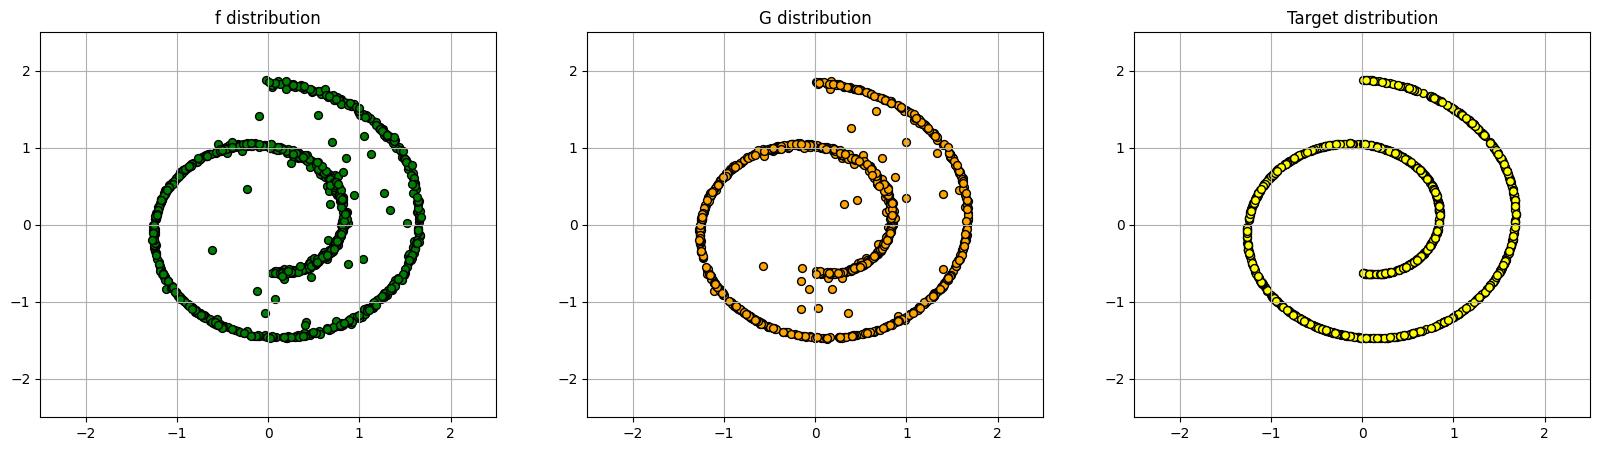

 90%|█████████ | 4505/5000 [04:58<02:02,  4.05it/s]

0.13401629030704498 -0.39600664377212524
0.1508367657661438 -0.39307907223701477
0.13082298636436462 -0.39122194051742554
0.14139890670776367 -0.3944549858570099


 90%|█████████ | 4509/5000 [04:59<01:14,  6.61it/s]

0.13838458061218262 -0.3799448609352112
0.14057891070842743 -0.40766385197639465
0.1352531760931015 -0.41646283864974976
0.14076416194438934 -0.4117201864719391


 90%|█████████ | 4513/5000 [04:59<00:50,  9.64it/s]

0.13949629664421082 -0.40654367208480835
0.13944007456302643 -0.4227644205093384
0.1469167172908783 -0.4270751476287842
0.14001552760601044 -0.4214398264884949


 90%|█████████ | 4517/5000 [04:59<00:39, 12.33it/s]

0.13344474136829376 -0.43723738193511963
0.13694871962070465 -0.4373232424259186
0.15400320291519165 -0.4347938299179077
0.15002787113189697 -0.44946566224098206


 90%|█████████ | 4521/5000 [04:59<00:33, 14.27it/s]

0.16526848077774048 -0.4474841058254242
0.16085664927959442 -0.4587399363517761
0.16032448410987854 -0.44679972529411316
0.16351188719272614 -0.44573408365249634


 90%|█████████ | 4525/5000 [05:00<00:30, 15.45it/s]

0.14981435239315033 -0.4671439826488495
0.14599624276161194 -0.47836732864379883
0.15551277995109558 -0.48393356800079346
0.15926741063594818 -0.4846329092979431


 91%|█████████ | 4529/5000 [05:00<00:29, 16.13it/s]

0.1721944510936737 -0.4816368520259857
0.15808075666427612 -0.4957513213157654
0.1662209928035736 -0.48897585272789
0.15008994936943054 -0.5094792246818542


 91%|█████████ | 4533/5000 [05:00<00:29, 15.88it/s]

0.15893317759037018 -0.49179884791374207
0.15768131613731384 -0.5160453915596008
0.15988598763942719 -0.5157864093780518
0.16311830282211304 -0.5006974935531616


 91%|█████████ | 4537/5000 [05:00<00:28, 16.33it/s]

0.15211015939712524 -0.500810444355011
0.14362812042236328 -0.5269072651863098
0.15846049785614014 -0.5159566402435303
0.1509191244840622 -0.5398797988891602


 91%|█████████ | 4541/5000 [05:01<00:27, 16.45it/s]

0.14864596724510193 -0.5362688302993774
0.1556977778673172 -0.5219953656196594
0.15195192396640778 -0.529464840888977
0.16559593379497528 -0.5671389698982239


 91%|█████████ | 4545/5000 [05:01<00:27, 16.58it/s]

0.16339488327503204 -0.5362581014633179
0.1619093418121338 -0.5425002574920654
0.1490883231163025 -0.5403439998626709
0.15452176332473755 -0.5519142150878906


 91%|█████████ | 4549/5000 [05:01<00:27, 16.68it/s]

0.15493284165859222 -0.5600835084915161
0.16971652209758759 -0.5484395623207092
0.15911316871643066 -0.5523821115493774
0.1725652515888214 -0.5345619916915894


 91%|█████████ | 4553/5000 [05:01<00:26, 16.74it/s]

0.15872080624103546 -0.5663204789161682
0.16668914258480072 -0.5556103587150574
0.16623178124427795 -0.5504090785980225
0.15188471972942352 -0.5508752465248108


 91%|█████████ | 4557/5000 [05:02<00:26, 16.82it/s]

0.15329667925834656 -0.5369729399681091
0.13875135779380798 -0.5604422092437744
0.14970751106739044 -0.5555468797683716
0.14416192471981049 -0.5485509037971497


 91%|█████████ | 4561/5000 [05:02<00:26, 16.82it/s]

0.16438838839530945 -0.5500045418739319
0.14792001247406006 -0.5725456476211548
0.16100263595581055 -0.5666388869285583
0.1592298299074173 -0.5639877915382385


 91%|█████████▏| 4565/5000 [05:02<00:26, 16.70it/s]

0.1685968041419983 -0.5445554256439209
0.15867388248443604 -0.5730692744255066
0.16172760725021362 -0.5365094542503357
0.1562740057706833 -0.5635198950767517


 91%|█████████▏| 4569/5000 [05:02<00:26, 16.21it/s]

0.1645776778459549 -0.5576351881027222
0.16866514086723328 -0.558253824710846
0.149405837059021 -0.5701687335968018
0.1557488739490509 -0.5738570094108582


 91%|█████████▏| 4573/5000 [05:03<00:26, 16.41it/s]

0.14966697990894318 -0.5654000639915466
0.14993402361869812 -0.5514253377914429
0.16183213889598846 -0.5549535155296326
0.1500091403722763 -0.564507246017456


 92%|█████████▏| 4577/5000 [05:03<00:25, 16.68it/s]

0.14657056331634521 -0.5560691952705383
0.15643201768398285 -0.5439257025718689
0.17050057649612427 -0.5289210677146912
0.1651928871870041 -0.5380747318267822


 92%|█████████▏| 4581/5000 [05:03<00:24, 16.88it/s]

0.17184363305568695 -0.5179277062416077
0.1615975946187973 -0.5404962301254272
0.17211318016052246 -0.507652997970581
0.16661983728408813 -0.5091596841812134


 92%|█████████▏| 4585/5000 [05:03<00:24, 16.85it/s]

0.16576698422431946 -0.4893431067466736
0.1557900756597519 -0.47617533802986145
0.16018743813037872 -0.4850078225135803
0.1514148712158203 -0.47656184434890747


 92%|█████████▏| 4589/5000 [05:03<00:24, 16.74it/s]

0.15382230281829834 -0.47190025448799133
0.14476054906845093 -0.465874582529068
0.1547679305076599 -0.4702380895614624
0.15967775881290436 -0.4723232090473175


 92%|█████████▏| 4593/5000 [05:04<00:24, 16.87it/s]

0.1524783968925476 -0.46362733840942383
0.15641920268535614 -0.46787694096565247
0.1621577888727188 -0.459990531206131
0.1553715020418167 -0.468435674905777


 92%|█████████▏| 4597/5000 [05:04<00:24, 16.74it/s]

0.15711480379104614 -0.4517332911491394
0.16560566425323486 -0.4270496964454651
0.16340680420398712 -0.43031764030456543
0.16875110566616058 -0.41487833857536316


 92%|█████████▏| 4601/5000 [05:04<00:23, 16.85it/s]

0.17428350448608398 -0.4082927405834198
0.15724177658557892 -0.40688326954841614
0.1639520823955536 -0.39152106642723083
0.15561486780643463 -0.4072675108909607


 92%|█████████▏| 4605/5000 [05:04<00:24, 16.28it/s]

0.14742445945739746 -0.39765095710754395
0.1704908013343811 -0.3820553719997406
0.15480998158454895 -0.3930701017379761
0.16476263105869293 -0.38197067379951477


 92%|█████████▏| 4609/5000 [05:05<00:23, 16.52it/s]

0.16088813543319702 -0.3787860870361328
0.16621693968772888 -0.372555673122406
0.15455231070518494 -0.3858695924282074
0.15254415571689606 -0.37291058897972107


 92%|█████████▏| 4613/5000 [05:05<00:23, 16.70it/s]

0.1538129597902298 -0.37394219636917114
0.1480354368686676 -0.378767728805542
0.16098003089427948 -0.37196314334869385
0.1529330164194107 -0.37170225381851196


 92%|█████████▏| 4617/5000 [05:05<00:23, 16.65it/s]

0.1730911284685135 -0.3728445768356323
0.14786246418952942 -0.35801735520362854
0.154992938041687 -0.36733877658843994
0.14789289236068726 -0.3610137403011322


 92%|█████████▏| 4621/5000 [05:05<00:22, 16.68it/s]

0.1556471884250641 -0.3595539331436157
0.14324085414409637 -0.37667521834373474
0.1553201526403427 -0.3509817123413086
0.16364173591136932 -0.35307806730270386


 92%|█████████▎| 4625/5000 [05:06<00:22, 16.71it/s]

0.16233482956886292 -0.3630710244178772
0.14501221477985382 -0.35820087790489197
0.1503906399011612 -0.3715229332447052
0.16190364956855774 -0.36926397681236267


 93%|█████████▎| 4629/5000 [05:06<00:22, 16.83it/s]

0.163569375872612 -0.36262422800064087
0.1662270724773407 -0.36344650387763977
0.16332118213176727 -0.3762401342391968
0.16547377407550812 -0.35239124298095703


 93%|█████████▎| 4633/5000 [05:06<00:21, 16.90it/s]

0.14208097755908966 -0.3579165041446686
0.14605143666267395 -0.3749476969242096
0.15099544823169708 -0.38291269540786743
0.14593961834907532 -0.388283371925354


 93%|█████████▎| 4637/5000 [05:06<00:22, 16.20it/s]

0.14646558463573456 -0.38678041100502014
0.14828699827194214 -0.37904584407806396
0.14702275395393372 -0.3813999891281128
0.1454850733280182 -0.3951781094074249


 93%|█████████▎| 4641/5000 [05:07<00:21, 16.60it/s]

0.14455729722976685 -0.40763863921165466
0.14928144216537476 -0.3906199038028717
0.14303305745124817 -0.4000173807144165
0.14288349449634552 -0.410634845495224


 93%|█████████▎| 4645/5000 [05:07<00:21, 16.80it/s]

0.144901305437088 -0.41512855887413025
0.15153495967388153 -0.4067901074886322
0.16543561220169067 -0.41738516092300415
0.15785108506679535 -0.4333449602127075


 93%|█████████▎| 4649/5000 [05:07<00:20, 16.85it/s]

0.14297711849212646 -0.4450243413448334
0.14940455555915833 -0.42799022793769836
0.13924692571163177 -0.44163668155670166
0.16139881312847137 -0.43936237692832947


 93%|█████████▎| 4653/5000 [05:07<00:20, 16.91it/s]

0.15341369807720184 -0.4463316798210144
0.16572384536266327 -0.44182345271110535
0.15619100630283356 -0.45323148369789124
0.1576894372701645 -0.46143782138824463


 93%|█████████▎| 4657/5000 [05:08<00:20, 16.93it/s]

0.1512550264596939 -0.4597119987010956
0.15104816854000092 -0.46216899156570435
0.15585003793239594 -0.4659505784511566
0.15685325860977173 -0.4624735414981842


 93%|█████████▎| 4661/5000 [05:08<00:20, 16.92it/s]

0.1492113620042801 -0.4711313843727112
0.16122525930404663 -0.47547227144241333
0.1383008062839508 -0.47053396701812744
0.15638276934623718 -0.4948829114437103


 93%|█████████▎| 4665/5000 [05:08<00:19, 16.92it/s]

0.1422756463289261 -0.49002471566200256
0.15292781591415405 -0.4893551766872406
0.14860698580741882 -0.5140339732170105
0.1620912104845047 -0.49777477979660034


 93%|█████████▎| 4669/5000 [05:08<00:20, 16.23it/s]

0.15824902057647705 -0.49507278203964233
0.15368391573429108 -0.5048199892044067
0.1660429984331131 -0.49415579438209534
0.16220970451831818 -0.5076591968536377


 93%|█████████▎| 4673/5000 [05:09<00:19, 16.57it/s]

0.15882094204425812 -0.4988718628883362
0.1504354476928711 -0.5112715363502502
0.15503337979316711 -0.49342477321624756
0.17867092788219452 -0.4937434196472168


 94%|█████████▎| 4677/5000 [05:09<00:19, 16.50it/s]

0.15521962940692902 -0.4938167929649353
0.14858552813529968 -0.5110586881637573
0.15794649720191956 -0.5144218802452087
0.16344092786312103 -0.5348751544952393


 94%|█████████▎| 4681/5000 [05:09<00:18, 16.81it/s]

0.16314329206943512 -0.5039856433868408
0.15679451823234558 -0.5220420360565186
0.17088629305362701 -0.5025579333305359
0.15912406146526337 -0.5111343264579773


 94%|█████████▎| 4685/5000 [05:09<00:18, 16.80it/s]

0.17068223655223846 -0.5288748741149902
0.1734553426504135 -0.5140463709831238
0.15888860821723938 -0.5308597683906555
0.158979132771492 -0.48851290345191956


 94%|█████████▍| 4689/5000 [05:09<00:18, 16.96it/s]

0.18148937821388245 -0.4964294135570526
0.16343092918395996 -0.5019623637199402
0.17052879929542542 -0.4938143491744995
0.18126514554023743 -0.5074434280395508


 94%|█████████▍| 4693/5000 [05:10<00:18, 16.21it/s]

0.15940004587173462 -0.5271434187889099
0.14883238077163696 -0.5077033042907715
0.1556018739938736 -0.494086354970932
0.15924915671348572 -0.5240952968597412


 94%|█████████▍| 4697/5000 [05:10<00:18, 16.34it/s]

0.17084231972694397 -0.510708212852478
0.1703178733587265 -0.5088539123535156
0.15672406554222107 -0.49480342864990234
0.17313945293426514 -0.4737427234649658


 94%|█████████▍| 4701/5000 [05:10<00:18, 16.49it/s]

0.18056955933570862 -0.4933973550796509
0.18124841153621674 -0.4925940930843353
0.16554996371269226 -0.4728093445301056
0.15214818716049194 -0.5023989081382751


 94%|█████████▍| 4705/5000 [05:10<00:18, 16.37it/s]

0.17753683030605316 -0.4883442223072052
0.16455212235450745 -0.4601932168006897
0.1652425080537796 -0.4559413492679596
0.15890789031982422 -0.4789201021194458


 94%|█████████▍| 4709/5000 [05:11<00:17, 16.63it/s]

0.16733381152153015 -0.44962024688720703
0.16514290869235992 -0.456238329410553
0.16454124450683594 -0.42761367559432983
0.16494478285312653 -0.44889241456985474


 94%|█████████▍| 4713/5000 [05:11<00:16, 16.91it/s]

0.16690079867839813 -0.463242769241333
0.16247870028018951 -0.4522552788257599
0.1672252118587494 -0.45159071683883667
0.17137017846107483 -0.4453331530094147


 94%|█████████▍| 4717/5000 [05:11<00:16, 16.98it/s]

0.16765707731246948 -0.44210273027420044
0.16916930675506592 -0.4285351037979126
0.16413657367229462 -0.4478987455368042
0.16463172435760498 -0.4418201148509979


 94%|█████████▍| 4721/5000 [05:11<00:16, 16.58it/s]

0.1622239500284195 -0.4480743408203125
0.15744218230247498 -0.45292335748672485
0.18024636805057526 -0.4407704770565033
0.157186359167099 -0.4579741954803467


 94%|█████████▍| 4725/5000 [05:12<00:16, 16.73it/s]

0.16546155512332916 -0.42953944206237793
0.15236209332942963 -0.43897297978401184
0.1467646062374115 -0.4225611686706543
0.16005323827266693 -0.42382434010505676


 95%|█████████▍| 4729/5000 [05:12<00:16, 16.14it/s]

0.1509941816329956 -0.4225662648677826
0.1663564294576645 -0.41088664531707764
0.1549912989139557 -0.42254146933555603
0.13979966938495636 -0.40655970573425293


 95%|█████████▍| 4733/5000 [05:12<00:16, 16.58it/s]

0.17072920501232147 -0.40672555565834045
0.14808990061283112 -0.4108315408229828
0.14981232583522797 -0.3887483775615692
0.16292056441307068 -0.4071493148803711


 95%|█████████▍| 4737/5000 [05:12<00:15, 16.76it/s]

0.14575865864753723 -0.4070349931716919
0.14720460772514343 -0.4040963351726532
0.15565145015716553 -0.4045204520225525
0.17108187079429626 -0.398127019405365


 95%|█████████▍| 4741/5000 [05:13<00:15, 16.68it/s]

0.1516716182231903 -0.4200272560119629
0.1509973406791687 -0.4087426960468292
0.16689150035381317 -0.41355568170547485
0.14921793341636658 -0.4190811216831207


 95%|█████████▍| 4745/5000 [05:13<00:15, 16.77it/s]

0.14999011158943176 -0.41742342710494995
0.15859156847000122 -0.4236352741718292
0.1631336659193039 -0.4271062910556793
0.1462239921092987 -0.4183969795703888


 95%|█████████▍| 4749/5000 [05:13<00:15, 16.68it/s]

0.146078422665596 -0.4300679564476013
0.1489776223897934 -0.43665972352027893
0.16027545928955078 -0.4495876133441925
0.15003634989261627 -0.4490554630756378


 95%|█████████▌| 4753/5000 [05:13<00:14, 16.86it/s]

0.1577637791633606 -0.4389970600605011
0.1469796746969223 -0.4520053267478943
0.158059224486351 -0.4644148647785187
0.13650155067443848 -0.466783344745636


 95%|█████████▌| 4757/5000 [05:14<00:14, 16.82it/s]

0.1485772430896759 -0.4636247456073761
0.1309707760810852 -0.4625270664691925
0.15548750758171082 -0.4708104431629181
0.15299668908119202 -0.4721594452857971


 95%|█████████▌| 4761/5000 [05:14<00:14, 16.09it/s]

0.14131036400794983 -0.4728531837463379
0.13434474170207977 -0.4851739704608917
0.14753028750419617 -0.48830685019493103
0.15102948248386383 -0.49784138798713684


 95%|█████████▌| 4765/5000 [05:14<00:14, 16.40it/s]

0.14251065254211426 -0.4918195903301239
0.12298543006181717 -0.5128817558288574
0.1541225016117096 -0.5170864462852478
0.12711606919765472 -0.5159210562705994


 95%|█████████▌| 4769/5000 [05:14<00:13, 16.55it/s]

0.14920933544635773 -0.5201169848442078
0.14777784049510956 -0.503976583480835
0.14461438357830048 -0.5249301195144653
0.14884473383426666 -0.5251978635787964


 95%|█████████▌| 4773/5000 [05:15<00:13, 16.47it/s]

0.13628755509853363 -0.5269482731819153
0.14586776494979858 -0.5388438701629639
0.14044401049613953 -0.5389769077301025
0.13114583492279053 -0.5420089960098267


 96%|█████████▌| 4777/5000 [05:15<00:13, 16.53it/s]

0.13298346102237701 -0.5397804379463196
0.15478916466236115 -0.566185712814331
0.15390808880329132 -0.5460455417633057
0.1467302143573761 -0.5572354793548584


 96%|█████████▌| 4781/5000 [05:15<00:13, 16.46it/s]

0.15992392599582672 -0.5506117343902588
0.15825358033180237 -0.5498000979423523
0.14764682948589325 -0.5342264771461487
0.1510131061077118 -0.5523154735565186


 96%|█████████▌| 4785/5000 [05:15<00:12, 16.73it/s]

0.16807442903518677 -0.528877854347229
0.15405093133449554 -0.5239301919937134
0.1558387577533722 -0.5292417407035828
0.1575945019721985 -0.5490413904190063


 96%|█████████▌| 4789/5000 [05:16<00:12, 16.60it/s]

0.15120655298233032 -0.559156060218811
0.1513739377260208 -0.5468357801437378
0.1558590531349182 -0.5331826210021973
0.15142807364463806 -0.5439960956573486


 96%|█████████▌| 4793/5000 [05:16<00:12, 16.20it/s]

0.16479630768299103 -0.5420339703559875
0.16250403225421906 -0.5434626936912537
0.15794672071933746 -0.5176324248313904
0.1616288274526596 -0.5100383758544922


 96%|█████████▌| 4797/5000 [05:16<00:12, 16.25it/s]

0.16205798089504242 -0.5376408100128174
0.17382462322711945 -0.5313234925270081
0.16040518879890442 -0.5231755375862122
0.16698282957077026 -0.5012203454971313


 96%|█████████▌| 4801/5000 [05:16<00:12, 16.56it/s]

0.1476561278104782 -0.5249900221824646
0.15681709349155426 -0.5210208892822266
0.17745505273342133 -0.5364570021629333
0.16688787937164307 -0.5102971196174622


 96%|█████████▌| 4805/5000 [05:17<00:11, 16.82it/s]

0.16431890428066254 -0.5310355424880981
0.14737765491008759 -0.5369778871536255
0.17371352016925812 -0.548294186592102
0.16286030411720276 -0.5466940999031067


 96%|█████████▌| 4809/5000 [05:17<00:11, 16.84it/s]

0.1604866087436676 -0.5442009568214417
0.1743275672197342 -0.5369203686714172
0.1638394445180893 -0.5278521776199341
0.16662365198135376 -0.526369035243988


 96%|█████████▋| 4813/5000 [05:17<00:11, 16.85it/s]

0.17334522306919098 -0.5317255258560181
0.16348475217819214 -0.5259227156639099
0.15942470729351044 -0.517521858215332
0.17185162007808685 -0.5274509787559509


 96%|█████████▋| 4817/5000 [05:17<00:11, 16.60it/s]

0.16635556519031525 -0.5200788378715515
0.16269266605377197 -0.5125299692153931
0.15499570965766907 -0.5080178380012512
0.14983044564723969 -0.4960453510284424


 96%|█████████▋| 4821/5000 [05:17<00:10, 16.77it/s]

0.1622210592031479 -0.5070028901100159
0.17785240709781647 -0.5059356093406677
0.18303827941417694 -0.4963851273059845
0.16839219629764557 -0.5061616897583008


 96%|█████████▋| 4825/5000 [05:18<00:10, 16.10it/s]

0.1800570785999298 -0.48706257343292236
0.16327188909053802 -0.4675235450267792
0.1699884980916977 -0.4808226227760315
0.1569974571466446 -0.4787905514240265


 97%|█████████▋| 4829/5000 [05:18<00:10, 16.52it/s]

0.1747356504201889 -0.46513500809669495
0.15813811123371124 -0.4510539174079895
0.15935133397579193 -0.4462224841117859
0.15951617062091827 -0.4350922405719757


 97%|█████████▋| 4833/5000 [05:18<00:10, 16.61it/s]

0.15637362003326416 -0.43622496724128723
0.15166376531124115 -0.40734899044036865
0.15062755346298218 -0.40609821677207947
0.1407623291015625 -0.41058385372161865


 97%|█████████▋| 4837/5000 [05:18<00:09, 16.60it/s]

0.14178809523582458 -0.4111477732658386
0.15309633314609528 -0.39910224080085754
0.1455979347229004 -0.4038606882095337
0.16661705076694489 -0.39459922909736633


 97%|█████████▋| 4841/5000 [05:19<00:09, 16.45it/s]

0.15263155102729797 -0.4075566530227661
0.1460198014974594 -0.390619158744812
0.16759157180786133 -0.3845793604850769
0.16759198904037476 -0.3725273907184601


 97%|█████████▋| 4845/5000 [05:19<00:09, 16.62it/s]

0.1545979380607605 -0.38033223152160645
0.14706844091415405 -0.3707544803619385
0.17029808461666107 -0.37285950779914856
0.1545742303133011 -0.3706437945365906


 97%|█████████▋| 4849/5000 [05:19<00:09, 16.61it/s]

0.17038096487522125 -0.3572341501712799
0.14892356097698212 -0.37250494956970215
0.1635659635066986 -0.3514781594276428
0.15988653898239136 -0.3648363947868347


 97%|█████████▋| 4853/5000 [05:19<00:09, 16.17it/s]

0.16003359854221344 -0.3877246677875519
0.15502789616584778 -0.3783424198627472
0.1519802212715149 -0.3660077750682831
0.1431947648525238 -0.3616248667240143


 97%|█████████▋| 4857/5000 [05:20<00:08, 16.13it/s]

0.15006239712238312 -0.3805791735649109
0.16626574099063873 -0.36692023277282715
0.15890631079673767 -0.3701423108577728
0.15227840840816498 -0.3780497610569


 97%|█████████▋| 4861/5000 [05:20<00:08, 16.35it/s]

0.14868462085723877 -0.3669062554836273
0.15280456840991974 -0.35443371534347534
0.1510731726884842 -0.36808717250823975
0.15338237583637238 -0.37513190507888794


 97%|█████████▋| 4865/5000 [05:20<00:08, 16.30it/s]

0.14914186298847198 -0.37203481793403625
0.15635022521018982 -0.3751438856124878
0.1572386771440506 -0.3811211585998535
0.13580718636512756 -0.3724854290485382


 97%|█████████▋| 4869/5000 [05:20<00:07, 16.56it/s]

0.15706013143062592 -0.37721043825149536
0.16324618458747864 -0.38676586747169495
0.15127089619636536 -0.3969338536262512
0.14205558598041534 -0.4016017019748688


 97%|█████████▋| 4873/5000 [05:21<00:07, 16.62it/s]

0.14259324967861176 -0.3988526165485382
0.1497347205877304 -0.40113958716392517
0.15939956903457642 -0.40500321984291077
0.1463990956544876 -0.4184386730194092


 98%|█████████▊| 4877/5000 [05:21<00:07, 16.79it/s]

0.16850900650024414 -0.4040982127189636
0.1597355604171753 -0.4120337665081024
0.1660088747739792 -0.4200074076652527
0.15119971334934235 -0.4175005555152893


 98%|█████████▊| 4881/5000 [05:21<00:07, 16.69it/s]

0.1484658569097519 -0.4213966727256775
0.15884658694267273 -0.4429599940776825
0.15664264559745789 -0.4344688057899475
0.16078975796699524 -0.4504595696926117


 98%|█████████▊| 4885/5000 [05:21<00:07, 16.04it/s]

0.14945431053638458 -0.460500568151474
0.13525456190109253 -0.44338932633399963
0.15966938436031342 -0.46961721777915955
0.1602291464805603 -0.44339486956596375


 98%|█████████▊| 4889/5000 [05:22<00:06, 16.47it/s]

0.1703234612941742 -0.47873541712760925
0.14805325865745544 -0.4771162271499634
0.1631934493780136 -0.4684031009674072
0.16080781817436218 -0.47548335790634155


 98%|█████████▊| 4893/5000 [05:22<00:06, 16.57it/s]

0.15247096121311188 -0.4778345227241516
0.16406697034835815 -0.4813266694545746
0.15145747363567352 -0.5000701546669006
0.14957666397094727 -0.5170676708221436


 98%|█████████▊| 4897/5000 [05:22<00:06, 16.66it/s]

0.15873318910598755 -0.4910353124141693
0.15734069049358368 -0.5006203651428223
0.14764590561389923 -0.5173293948173523
0.1440693587064743 -0.5272058248519897


 98%|█████████▊| 4901/5000 [05:22<00:05, 16.77it/s]

0.15415744483470917 -0.5097981691360474
0.1482406109571457 -0.5339536666870117
0.1461300253868103 -0.5200050473213196
0.15140372514724731 -0.5284777879714966


 98%|█████████▊| 4905/5000 [05:23<00:05, 16.74it/s]

0.14987999200820923 -0.5322003364562988
0.16418857872486115 -0.542151927947998
0.15040676295757294 -0.5440121293067932
0.1584276407957077 -0.5322405099868774


 98%|█████████▊| 4909/5000 [05:23<00:05, 16.69it/s]

0.1498158574104309 -0.5340043306350708
0.1564459502696991 -0.5382150411605835
0.1574806571006775 -0.5519980788230896
0.14964425563812256 -0.5509396195411682


 98%|█████████▊| 4913/5000 [05:23<00:05, 15.70it/s]

0.1489805281162262 -0.5428216457366943
0.15412059426307678 -0.5548493266105652
0.15515656769275665 -0.5612587332725525
0.16009128093719482 -0.5481629967689514


 98%|█████████▊| 4917/5000 [05:23<00:05, 16.06it/s]

0.1496468335390091 -0.5781623721122742
0.15486133098602295 -0.5859711766242981
0.14357587695121765 -0.5688827037811279
0.15225932002067566 -0.571373462677002


 98%|█████████▊| 4921/5000 [05:24<00:04, 16.37it/s]

0.15033084154129028 -0.5600423812866211
0.14217539131641388 -0.5602338910102844
0.16736994683742523 -0.5408549904823303
0.1786695271730423 -0.5606057047843933


 98%|█████████▊| 4925/5000 [05:24<00:04, 16.64it/s]

0.16484318673610687 -0.5546752214431763
0.16990987956523895 -0.5401396751403809
0.1614924520254135 -0.5612223148345947
0.17487791180610657 -0.5472692847251892


 99%|█████████▊| 4929/5000 [05:24<00:04, 16.64it/s]

0.16932260990142822 -0.549088716506958
0.16625939309597015 -0.5535245537757874
0.15925930440425873 -0.5253627300262451
0.163518488407135 -0.579211950302124


 99%|█████████▊| 4933/5000 [05:24<00:04, 16.58it/s]

0.1623559147119522 -0.5376180410385132
0.16392412781715393 -0.5506958961486816
0.16594214737415314 -0.5313609838485718
0.1742326021194458 -0.5210671424865723


 99%|█████████▊| 4937/5000 [05:25<00:03, 16.71it/s]

0.17716854810714722 -0.5358452796936035
0.17325782775878906 -0.5221523642539978
0.16759532690048218 -0.5153997540473938
0.17873147130012512 -0.503334641456604


 99%|█████████▉| 4941/5000 [05:25<00:03, 16.64it/s]

0.1644149273633957 -0.4964013695716858
0.16528023779392242 -0.5076166987419128
0.17905138432979584 -0.4892488718032837
0.16594424843788147 -0.496781587600708


 99%|█████████▉| 4945/5000 [05:25<00:03, 16.32it/s]

0.15505476295948029 -0.4916570782661438
0.1703338772058487 -0.48619544506073
0.15406259894371033 -0.48456549644470215
0.15498465299606323 -0.47919610142707825


 99%|█████████▉| 4949/5000 [05:25<00:03, 16.64it/s]

0.16166003048419952 -0.4727073013782501
0.15455923974514008 -0.4786638617515564
0.16653165221214294 -0.47240564227104187
0.15292878448963165 -0.4571504592895508


 99%|█████████▉| 4953/5000 [05:26<00:02, 16.80it/s]

0.165658101439476 -0.4509490430355072
0.1554180532693863 -0.4337552487850189
0.14633598923683167 -0.4209679663181305
0.15674372017383575 -0.41846445202827454


 99%|█████████▉| 4957/5000 [05:26<00:02, 16.68it/s]

0.15303269028663635 -0.4165359437465668
0.14327627420425415 -0.3996788263320923
0.1523011177778244 -0.4027767479419708
0.15459968149662018 -0.3871689736843109


 99%|█████████▉| 4961/5000 [05:26<00:02, 16.54it/s]

0.15265673398971558 -0.39923498034477234
0.15594425797462463 -0.39392656087875366
0.1454782336950302 -0.3823007345199585
0.15642599761486053 -0.3877037763595581


 99%|█████████▉| 4965/5000 [05:26<00:02, 16.47it/s]

0.1560133695602417 -0.38980042934417725
0.17038051784038544 -0.37066781520843506
0.14287373423576355 -0.39805349707603455
0.1615607738494873 -0.3830105662345886


 99%|█████████▉| 4969/5000 [05:26<00:01, 16.49it/s]

0.14906227588653564 -0.3898240625858307
0.16410154104232788 -0.3818896412849426
0.16828496754169464 -0.38126736879348755
0.14952553808689117 -0.3931078016757965


 99%|█████████▉| 4973/5000 [05:27<00:01, 15.81it/s]

0.15828706324100494 -0.38014042377471924
0.15281333029270172 -0.39967185258865356
0.1742943674325943 -0.3840419054031372
0.15434382855892181 -0.39163050055503845


100%|█████████▉| 4977/5000 [05:27<00:01, 16.44it/s]

0.16967028379440308 -0.4051115810871124
0.1624976545572281 -0.3823566138744354
0.1520734578371048 -0.3979564607143402
0.16290757060050964 -0.40152907371520996


100%|█████████▉| 4981/5000 [05:27<00:01, 16.57it/s]

0.17356255650520325 -0.3830861449241638
0.16609245538711548 -0.4011446535587311
0.16849078238010406 -0.39087122678756714
0.16810965538024902 -0.3942960500717163


100%|█████████▉| 4985/5000 [05:27<00:00, 16.65it/s]

0.1664787232875824 -0.41529929637908936
0.17687034606933594 -0.4177621006965637
0.16751033067703247 -0.403206467628479
0.16218267381191254 -0.4076509475708008


100%|█████████▉| 4989/5000 [05:28<00:00, 16.43it/s]

0.15963423252105713 -0.4154300093650818
0.15955810248851776 -0.4087648093700409
0.16954483091831207 -0.4268084466457367
0.17145191133022308 -0.4268205165863037


100%|█████████▉| 4993/5000 [05:28<00:00, 16.62it/s]

0.17307430505752563 -0.4291364848613739
0.16933974623680115 -0.41194358468055725
0.16606245934963226 -0.40919229388237
0.15979532897472382 -0.4080311357975006


100%|█████████▉| 4997/5000 [05:28<00:00, 16.58it/s]

0.14254386723041534 -0.4171147644519806
0.15800713002681732 -0.4128130078315735
0.16073670983314514 -0.4196816682815552
0.14393369853496552 -0.43105870485305786


100%|██████████| 5000/5000 [05:28<00:00, 15.20it/s]

0.13881123065948486 -0.43618500232696533
0.13622328639030457 -0.4379849433898926
0.16112422943115234 -0.43154269456863403


In [5]:
MAX_STEPS = 5000

stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=1000)

In [7]:
GAMMA = 0.5
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 5000

G mse: 0.18284077942371368
sde mse: 0.45525410771369934
G var: 0.05565127730369568
sde var: 0.31272220611572266


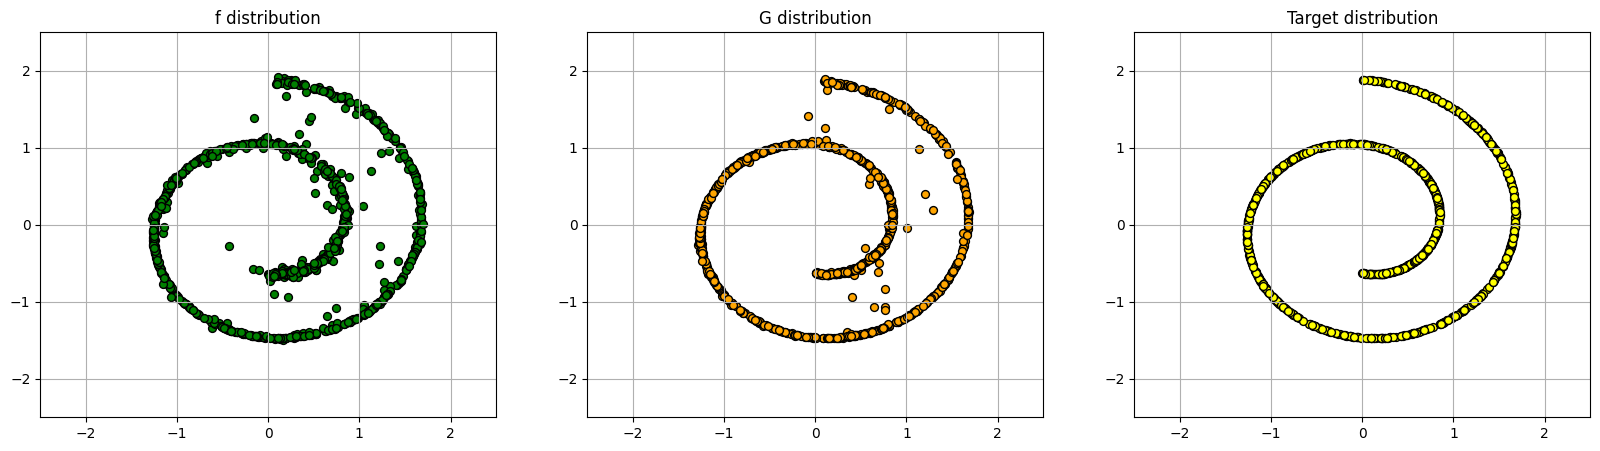

 90%|█████████ | 4505/5000 [05:01<02:05,  3.95it/s]

0.813716471195221 -2.029876470565796
0.9677047729492188 -2.025217294692993
0.9134916067123413 -2.0459327697753906
0.8227761387825012 -1.9996042251586914


 90%|█████████ | 4509/5000 [05:01<01:16,  6.45it/s]

0.7327673435211182 -2.0411465167999268
1.007928490638733 -2.053093433380127
0.8924005031585693 -2.036865234375
0.9258033037185669 -2.044703960418701


 90%|█████████ | 4513/5000 [05:01<00:52,  9.36it/s]

0.8580552339553833 -2.05145525932312
0.6641932129859924 -2.0660693645477295
0.7577343583106995 -2.0756266117095947
0.7932912707328796 -2.0370943546295166


 90%|█████████ | 4517/5000 [05:02<00:40, 12.02it/s]

0.7544505596160889 -2.047117233276367
0.9874517917633057 -2.0838491916656494
0.9227163195610046 -2.090275526046753
1.036209225654602 -2.0142362117767334


 90%|█████████ | 4521/5000 [05:02<00:34, 13.89it/s]

0.7467337250709534 -2.1057519912719727
0.7747063040733337 -2.0926506519317627
0.8577600717544556 -2.1589317321777344
0.8609122633934021 -2.1038992404937744


 90%|█████████ | 4525/5000 [05:02<00:31, 15.14it/s]

0.7080780863761902 -2.2013306617736816
0.9750475287437439 -2.1260814666748047
1.0042471885681152 -2.1486330032348633
1.0637444257736206 -2.185394287109375


 91%|█████████ | 4529/5000 [05:02<00:30, 15.38it/s]

0.8640413880348206 -2.1160330772399902
0.6447405219078064 -2.1590561866760254
0.8916854858398438 -2.177628517150879
0.8960144519805908 -2.1991608142852783


 91%|█████████ | 4533/5000 [05:03<00:29, 15.92it/s]

0.8379823565483093 -2.147326707839966
0.8039363622665405 -2.1851577758789062
0.7260702252388 -2.1457643508911133
0.8746927380561829 -2.1620724201202393


 91%|█████████ | 4537/5000 [05:03<00:28, 16.30it/s]

0.6149455308914185 -2.1701412200927734
1.0458425283432007 -2.1220693588256836
0.9615378379821777 -2.090907573699951
0.8600277304649353 -2.108942985534668


 91%|█████████ | 4541/5000 [05:03<00:27, 16.57it/s]

1.170158863067627 -2.095122814178467
0.6268598437309265 -2.128995895385742
0.856090784072876 -2.088897943496704
0.8355441689491272 -2.121321201324463


 91%|█████████ | 4545/5000 [05:03<00:27, 16.67it/s]

0.9631065726280212 -2.1259312629699707
1.019830584526062 -2.1483585834503174
0.9948378205299377 -2.157008409500122
1.062294602394104 -2.141472339630127


 91%|█████████ | 4549/5000 [05:04<00:26, 16.81it/s]

0.8677331209182739 -2.1075363159179688
0.9326314330101013 -2.1029458045959473
0.8527870774269104 -2.01650333404541
0.8693577647209167 -2.054199695587158


 91%|█████████ | 4553/5000 [05:04<00:26, 16.72it/s]

0.8983068466186523 -2.0471909046173096
0.8771260976791382 -2.0423424243927
0.7448767423629761 -2.0186872482299805
1.010436773300171 -1.987916350364685


 91%|█████████ | 4557/5000 [05:04<00:26, 16.69it/s]

0.7908129096031189 -2.0161075592041016
0.83208167552948 -1.9514398574829102
0.7261980175971985 -1.9938706159591675
0.8853538632392883 -1.948209524154663


 91%|█████████ | 4561/5000 [05:04<00:27, 16.22it/s]

0.7625239491462708 -1.9213201999664307
0.8659208416938782 -1.9382474422454834
0.9237686991691589 -1.9009652137756348
0.8796803951263428 -1.9071871042251587


 91%|█████████▏| 4565/5000 [05:04<00:26, 16.38it/s]

0.6449101567268372 -1.9708563089370728
0.6937456727027893 -1.9581677913665771
0.9201945066452026 -1.937687873840332
0.7145974636077881 -1.8992151021957397


 91%|█████████▏| 4569/5000 [05:05<00:26, 16.48it/s]

0.913709282875061 -1.94794762134552
0.8480494022369385 -1.8857054710388184
0.9723677039146423 -1.9022293090820312
0.8864006996154785 -1.928229570388794


 91%|█████████▏| 4573/5000 [05:05<00:25, 16.43it/s]

0.7962091565132141 -1.9551893472671509
0.8081780076026917 -1.9399514198303223
0.9534054398536682 -1.9499224424362183
0.8140835762023926 -1.989312767982483


 92%|█████████▏| 4577/5000 [05:05<00:25, 16.56it/s]

0.8905830979347229 -1.973147988319397
0.7727896571159363 -1.883374571800232
0.9013519883155823 -1.924320936203003
0.8640605211257935 -1.9525808095932007


 92%|█████████▏| 4581/5000 [05:05<00:25, 16.60it/s]

0.7710787057876587 -1.985324501991272
0.9091387987136841 -1.9630335569381714
0.9206058979034424 -1.9583494663238525
0.9584551453590393 -1.9564036130905151


 92%|█████████▏| 4585/5000 [05:06<00:24, 16.61it/s]

0.7803633809089661 -1.9875569343566895
0.7530809640884399 -1.9639781713485718
0.9700766801834106 -1.9248888492584229
0.6967742443084717 -2.000946283340454


 92%|█████████▏| 4589/5000 [05:06<00:25, 16.16it/s]

1.014420986175537 -1.878731369972229
0.8655038475990295 -1.9082801342010498
0.7898754477500916 -1.987478494644165
0.8926646113395691 -1.9868242740631104


 92%|█████████▏| 4593/5000 [05:06<00:24, 16.33it/s]

0.8116032481193542 -1.9273521900177002
0.6275972723960876 -1.907545566558838
0.8988136649131775 -2.006819009780884
0.8724973201751709 -1.9077247381210327


 92%|█████████▏| 4597/5000 [05:06<00:24, 16.41it/s]

1.086937427520752 -1.9601404666900635
1.165364384651184 -1.946884274482727
0.7863160967826843 -1.9453444480895996
1.031631350517273 -1.8309565782546997


 92%|█████████▏| 4601/5000 [05:07<00:24, 16.48it/s]

0.8381490707397461 -1.8418200016021729
1.1395307779312134 -1.9208101034164429
0.8994705677032471 -1.845349907875061
0.9428561925888062 -1.905949354171753


 92%|█████████▏| 4605/5000 [05:07<00:24, 16.37it/s]

0.9604445695877075 -1.8967852592468262
0.6372551918029785 -1.8286157846450806
0.6749933362007141 -1.9169467687606812
0.8275978565216064 -2.022984266281128


 92%|█████████▏| 4609/5000 [05:07<00:23, 16.55it/s]

0.9034669399261475 -1.9142566919326782
0.828934371471405 -1.8980481624603271
0.6970627307891846 -1.8396251201629639
0.7845033407211304 -1.8917349576950073


 92%|█████████▏| 4613/5000 [05:07<00:23, 16.59it/s]

0.870025634765625 -1.7461134195327759
0.9185293316841125 -1.851062536239624
0.6531018614768982 -1.8503857851028442
0.862887978553772 -1.9258136749267578


 92%|█████████▏| 4617/5000 [05:08<00:23, 16.57it/s]

0.7940370440483093 -1.9182322025299072
0.7671153545379639 -1.9792554378509521
0.8565989136695862 -1.9326229095458984
0.9219565391540527 -1.9705884456634521


 92%|█████████▏| 4621/5000 [05:08<00:23, 16.16it/s]

0.7835363745689392 -1.9725311994552612
0.9099677801132202 -2.019284725189209
0.7759119272232056 -2.0123512744903564
0.9809252023696899 -1.9970017671585083


 92%|█████████▎| 4625/5000 [05:08<00:22, 16.41it/s]

0.6558069586753845 -1.9624756574630737
0.9392550587654114 -1.972703218460083
1.1609488725662231 -1.9933345317840576
0.8463751673698425 -1.9854648113250732


 93%|█████████▎| 4629/5000 [05:08<00:22, 16.66it/s]

0.6563283205032349 -2.0270752906799316
0.9040238857269287 -2.0044078826904297
0.7094361186027527 -2.0155160427093506
0.7938516736030579 -2.010688304901123


 93%|█████████▎| 4633/5000 [05:09<00:21, 16.68it/s]

0.7817489504814148 -2.0361907482147217
0.6682348847389221 -2.0822529792785645
0.9703344702720642 -2.074951648712158
0.8849947452545166 -2.0830841064453125


 93%|█████████▎| 4637/5000 [05:09<00:21, 16.69it/s]

0.8303592205047607 -2.0585532188415527
0.6870538592338562 -2.0883677005767822
0.9100005030632019 -2.1091837882995605
1.1093577146530151 -2.108215808868408


 93%|█████████▎| 4641/5000 [05:09<00:21, 16.48it/s]

0.7436860203742981 -2.0985991954803467
0.8612788915634155 -2.1461000442504883
0.651760458946228 -2.1658778190612793
0.8463300466537476 -2.1537256240844727


 93%|█████████▎| 4645/5000 [05:09<00:21, 16.60it/s]

0.8851012587547302 -2.2126107215881348
1.0469874143600464 -2.150245189666748
1.0971474647521973 -2.2361724376678467
0.7076389789581299 -2.2566308975219727


 93%|█████████▎| 4649/5000 [05:10<00:21, 16.04it/s]

0.7669030427932739 -2.2403805255889893
0.8930752277374268 -2.280128002166748
0.748014509677887 -2.2550535202026367
0.9682521224021912 -2.2780067920684814


 93%|█████████▎| 4653/5000 [05:10<00:20, 16.61it/s]

0.9845330715179443 -2.2906689643859863
0.8966319561004639 -2.33599853515625
0.8369365334510803 -2.2790110111236572
0.9884766340255737 -2.3064000606536865


 93%|█████████▎| 4657/5000 [05:10<00:20, 16.63it/s]

0.8917154669761658 -2.333411455154419
0.8208630084991455 -2.2897467613220215
0.8096626996994019 -2.360252857208252
0.8100171685218811 -2.3393726348876953


 93%|█████████▎| 4661/5000 [05:10<00:20, 16.69it/s]

0.7667026519775391 -2.3286571502685547
0.8611716032028198 -2.275632858276367
1.0389622449874878 -2.351191520690918
0.7193780541419983 -2.341557741165161


 93%|█████████▎| 4665/5000 [05:11<00:20, 16.68it/s]

0.6267626881599426 -2.3149259090423584
0.8333159685134888 -2.302654981613159
0.9116910696029663 -2.3145225048065186
0.8433514833450317 -2.3321454524993896


 93%|█████████▎| 4669/5000 [05:11<00:19, 16.81it/s]

0.7273635864257812 -2.3167731761932373
1.0659918785095215 -2.335193157196045
0.8367162942886353 -2.3578433990478516
0.8206230401992798 -2.391648292541504


 93%|█████████▎| 4673/5000 [05:11<00:19, 16.90it/s]

0.8886314034461975 -2.361302375793457
0.96570885181427 -2.309931755065918
1.0353368520736694 -2.3408584594726562
0.8418594598770142 -2.3184027671813965


 94%|█████████▎| 4677/5000 [05:11<00:19, 16.87it/s]

0.921075701713562 -2.3633763790130615
0.8608601689338684 -2.319108247756958
0.8843557834625244 -2.30033802986145
0.7846670746803284 -2.3109076023101807


 94%|█████████▎| 4681/5000 [05:12<00:19, 16.19it/s]

1.1136243343353271 -2.334510326385498
0.9667961001396179 -2.3419206142425537
1.0401875972747803 -2.2504966259002686
0.823514997959137 -2.2833003997802734


 94%|█████████▎| 4685/5000 [05:12<00:19, 16.43it/s]

0.9571087956428528 -2.2464981079101562
0.6446323990821838 -2.2240958213806152
0.9122459888458252 -2.1832659244537354
0.7729677557945251 -2.175325393676758


 94%|█████████▍| 4689/5000 [05:12<00:18, 16.58it/s]

0.9035542011260986 -2.070495128631592
0.9988501667976379 -2.205590009689331
1.00971519947052 -2.025641679763794
1.2471277713775635 -1.973374843597412


 94%|█████████▍| 4693/5000 [05:12<00:18, 16.66it/s]

1.0356181859970093 -2.0897555351257324
0.7087359428405762 -2.006722927093506
1.2343987226486206 -1.9676214456558228
0.9682998657226562 -1.9790035486221313


 94%|█████████▍| 4697/5000 [05:12<00:18, 16.63it/s]

0.974799394607544 -2.0254080295562744
0.8474842309951782 -2.0121333599090576
0.9428335428237915 -1.9873404502868652
0.8150598406791687 -2.032837390899658


 94%|█████████▍| 4701/5000 [05:13<00:17, 16.77it/s]

0.8050296902656555 -2.0185039043426514
0.7295332551002502 -1.9265427589416504
0.6740615367889404 -1.9392492771148682
0.7970714569091797 -1.9150640964508057


 94%|█████████▍| 4705/5000 [05:13<00:17, 16.51it/s]

0.695817768573761 -1.9631646871566772
0.8864927291870117 -1.9526410102844238
0.6702638864517212 -1.9053093194961548
0.7615411281585693 -1.9175008535385132


 94%|█████████▍| 4709/5000 [05:13<00:18, 15.92it/s]

0.9121490716934204 -1.9217945337295532
0.9460126161575317 -1.9295883178710938
1.0601396560668945 -1.9339778423309326
0.9318140149116516 -1.9703130722045898


 94%|█████████▍| 4713/5000 [05:13<00:17, 16.32it/s]

0.8000103831291199 -1.9878162145614624
0.7246584892272949 -1.9799022674560547
0.8304546475410461 -1.9943594932556152
0.6214603781700134 -2.022465944290161


 94%|█████████▍| 4717/5000 [05:14<00:16, 16.65it/s]

0.8864270448684692 -2.0595929622650146
0.9258108735084534 -2.063704252243042
0.7253501415252686 -2.0348119735717773
0.7784621119499207 -2.091303586959839


 94%|█████████▍| 4721/5000 [05:14<00:16, 16.73it/s]

0.7770495414733887 -2.192143201828003
0.7337936758995056 -2.172165632247925
0.7761914730072021 -2.1748046875
1.058899998664856 -2.1941442489624023


 94%|█████████▍| 4725/5000 [05:14<00:16, 16.72it/s]

0.7781025171279907 -2.248244285583496
0.7517656683921814 -2.210554599761963
0.9185377955436707 -2.2059109210968018
0.8191931843757629 -2.262070894241333


 95%|█████████▍| 4729/5000 [05:14<00:16, 16.75it/s]

1.0231304168701172 -2.2486371994018555
0.6811296343803406 -2.252750873565674
0.915349543094635 -2.259857416152954
0.7641699314117432 -2.313385009765625


 95%|█████████▍| 4733/5000 [05:15<00:15, 16.72it/s]

0.8363156914710999 -2.2500827312469482
0.9445558786392212 -2.2549595832824707
0.8003301620483398 -2.283294916152954
0.7912871837615967 -2.28951358795166


 95%|█████████▍| 4737/5000 [05:15<00:16, 16.06it/s]

0.905886709690094 -2.269596576690674
0.6298010349273682 -2.2205281257629395
0.8565428256988525 -2.199291706085205
0.7358598709106445 -2.2918081283569336


 95%|█████████▍| 4741/5000 [05:15<00:15, 16.50it/s]

1.144588828086853 -2.2366442680358887
0.6761816740036011 -2.2329349517822266
0.8777692914009094 -2.2116968631744385
0.9068595767021179 -2.2724556922912598


 95%|█████████▍| 4745/5000 [05:15<00:15, 16.48it/s]

0.750889778137207 -2.2010605335235596
0.6507030129432678 -2.188336133956909
0.9723528027534485 -2.159747838973999
1.1342943906784058 -2.0703885555267334


 95%|█████████▍| 4749/5000 [05:16<00:15, 16.53it/s]

0.8362324237823486 -2.213371753692627
0.9982565641403198 -2.054466724395752
0.6734182238578796 -2.197183847427368
0.961046040058136 -2.2668139934539795


 95%|█████████▌| 4753/5000 [05:16<00:15, 16.25it/s]

0.6132669448852539 -2.288947820663452
0.5956647992134094 -2.2113583087921143
1.1137477159500122 -2.27902889251709
0.8246055245399475 -2.234622001647949


 95%|█████████▌| 4757/5000 [05:16<00:14, 16.27it/s]

0.8487468957901001 -2.273080348968506
0.8722373247146606 -2.343569040298462
0.7528024911880493 -2.383108615875244
0.908659040927887 -2.3605494499206543


 95%|█████████▌| 4761/5000 [05:16<00:14, 16.44it/s]

0.9719799160957336 -2.449526071548462
1.0154235363006592 -2.484785318374634
0.9328769445419312 -2.4964470863342285
0.9535987377166748 -2.4172840118408203


 95%|█████████▌| 4765/5000 [05:17<00:14, 15.80it/s]

0.8721351623535156 -2.4585258960723877
0.9217548370361328 -2.4490010738372803
0.8958554863929749 -2.5269205570220947
1.1287524700164795 -2.4686291217803955


 95%|█████████▌| 4769/5000 [05:17<00:14, 16.25it/s]

0.8208573460578918 -2.508237838745117
0.9431779384613037 -2.5125038623809814
0.8849080204963684 -2.510537624359131
0.8353646397590637 -2.546860933303833


 95%|█████████▌| 4773/5000 [05:17<00:13, 16.47it/s]

0.8447487950325012 -2.5314111709594727
1.1154521703720093 -2.544199228286743
0.9806985855102539 -2.5702600479125977
0.6723302006721497 -2.5414044857025146


 96%|█████████▌| 4777/5000 [05:17<00:13, 16.59it/s]

0.9460070729255676 -2.5499327182769775
0.9475184679031372 -2.4912467002868652
0.729426383972168 -2.4761905670166016
0.9872211217880249 -2.505009889602661


 96%|█████████▌| 4781/5000 [05:18<00:13, 16.55it/s]

1.0555546283721924 -2.467909336090088
0.851631760597229 -2.4474868774414062
0.907264769077301 -2.472198247909546
0.9090107679367065 -2.4410643577575684


 96%|█████████▌| 4785/5000 [05:18<00:12, 16.68it/s]

0.728736162185669 -2.4738996028900146
0.7284747362136841 -2.4591989517211914
0.9933991432189941 -2.4598631858825684
0.841366171836853 -2.4918596744537354


 96%|█████████▌| 4789/5000 [05:18<00:12, 16.75it/s]

0.6311610341072083 -2.5081958770751953
0.9908546209335327 -2.474778175354004
0.9001182913780212 -2.507061243057251
0.8131665587425232 -2.509395122528076


 96%|█████████▌| 4793/5000 [05:18<00:12, 15.97it/s]

0.9446367025375366 -2.5554168224334717
0.8966304063796997 -2.4768624305725098
0.7905528545379639 -2.5102245807647705
1.059737205505371 -2.55820369720459


 96%|█████████▌| 4797/5000 [05:19<00:12, 16.40it/s]

1.031304121017456 -2.5901951789855957
0.8768341541290283 -2.535879611968994
0.8623670339584351 -2.554353952407837
0.8663275837898254 -2.5642950534820557


 96%|█████████▌| 4801/5000 [05:19<00:12, 16.50it/s]

0.8371958136558533 -2.5865416526794434
0.8145483136177063 -2.6192619800567627
0.6783219575881958 -2.6174447536468506
0.7409656047821045 -2.636781930923462


 96%|█████████▌| 4805/5000 [05:19<00:11, 16.55it/s]

0.843960165977478 -2.616736888885498
0.7928020358085632 -2.607330799102783
1.224633812904358 -2.611950397491455
0.8868124485015869 -2.6091885566711426


 96%|█████████▌| 4809/5000 [05:19<00:11, 16.35it/s]

0.7137051820755005 -2.58731746673584
0.8653290271759033 -2.6152467727661133
0.700592577457428 -2.5813097953796387
0.9785079956054688 -2.5778307914733887


 96%|█████████▋| 4813/5000 [05:20<00:11, 16.53it/s]

0.9640781283378601 -2.6005589962005615
0.9130691885948181 -2.5404152870178223
0.6526603698730469 -2.5395357608795166
0.9410332441329956 -2.5157339572906494


 96%|█████████▋| 4817/5000 [05:20<00:11, 16.59it/s]

0.6017686724662781 -2.5278868675231934
1.162986397743225 -2.4788482189178467
0.8615298867225647 -2.494180679321289
0.7217947840690613 -2.468545913696289


 96%|█████████▋| 4821/5000 [05:20<00:11, 15.93it/s]

0.8164070248603821 -2.4392075538635254
0.7015235424041748 -2.442704439163208
0.7616940140724182 -2.379380226135254
0.655943751335144 -2.3847970962524414


 96%|█████████▋| 4825/5000 [05:20<00:10, 16.21it/s]

0.8009171485900879 -2.380227565765381
0.8401547074317932 -2.382021188735962
0.960440993309021 -2.4462828636169434
0.9551665186882019 -2.3749747276306152


 97%|█████████▋| 4829/5000 [05:21<00:10, 16.39it/s]

1.0393874645233154 -2.417473077774048
0.7836057543754578 -2.389464855194092
0.7598053812980652 -2.406798839569092
0.8842182159423828 -2.4672017097473145


 97%|█████████▋| 4833/5000 [05:21<00:10, 16.47it/s]

0.9147407412528992 -2.4863975048065186
0.8955994844436646 -2.5027997493743896
0.8088302612304688 -2.4490439891815186
0.824070394039154 -2.4383926391601562


 97%|█████████▋| 4837/5000 [05:21<00:09, 16.74it/s]

0.8428781628608704 -2.4448721408843994
0.9915993809700012 -2.4749088287353516
1.0607428550720215 -2.492673635482788
0.672574520111084 -2.51774525642395


 97%|█████████▋| 4841/5000 [05:21<00:09, 16.78it/s]

0.8429924845695496 -2.4966468811035156
0.6950905323028564 -2.5352792739868164
0.8014919757843018 -2.559468984603882
1.1953513622283936 -2.521406888961792


 97%|█████████▋| 4845/5000 [05:21<00:09, 16.89it/s]

0.8489495515823364 -2.5738375186920166
0.8372751474380493 -2.532221794128418
0.9991167783737183 -2.5569908618927
1.1096364259719849 -2.5108859539031982


 97%|█████████▋| 4849/5000 [05:22<00:09, 16.25it/s]

0.9108151793479919 -2.572183609008789
1.2492458820343018 -2.549837112426758
0.9443210959434509 -2.5561513900756836
0.8735106587409973 -2.539423942565918


 97%|█████████▋| 4853/5000 [05:22<00:09, 16.31it/s]

1.0979770421981812 -2.5715370178222656
0.9358289241790771 -2.5451860427856445
0.8973299264907837 -2.5149154663085938
0.69280606508255 -2.5549333095550537


 97%|█████████▋| 4857/5000 [05:22<00:08, 16.57it/s]

0.8360973000526428 -2.5387930870056152
0.8423089981079102 -2.5524985790252686
1.0613408088684082 -2.5391221046447754
0.9507225751876831 -2.5156822204589844


 97%|█████████▋| 4861/5000 [05:22<00:08, 16.34it/s]

1.1557822227478027 -2.528502941131592
0.9016721248626709 -2.5344204902648926
0.869439423084259 -2.55365252494812
1.025534749031067 -2.581228494644165


 97%|█████████▋| 4865/5000 [05:23<00:08, 16.20it/s]

0.867877185344696 -2.5256991386413574
0.6194556355476379 -2.5273613929748535
0.911956250667572 -2.5908849239349365
0.9549211263656616 -2.533771514892578


 97%|█████████▋| 4869/5000 [05:23<00:08, 16.32it/s]

0.6292423605918884 -2.5249245166778564
0.7938522696495056 -2.53556489944458
1.045633316040039 -2.535431146621704
0.7872164845466614 -2.588009834289551


 97%|█████████▋| 4873/5000 [05:23<00:07, 16.43it/s]

0.8110817670822144 -2.559751510620117
0.8200073838233948 -2.580369234085083
1.0003623962402344 -2.553152084350586
0.942840576171875 -2.544135808944702


 98%|█████████▊| 4875/5000 [05:23<00:07, 16.40it/s]

0.9771109819412231 -2.541717290878296
0.6974932551383972 -2.5587730407714844
0.7656559348106384 -2.5672848224639893
0.748247504234314 -2.569352626800537


 98%|█████████▊| 4881/5000 [05:24<00:07, 16.29it/s]

0.8938170075416565 -2.541217803955078
0.9709893465042114 -2.576857089996338
0.8852592706680298 -2.558722496032715
1.1640264987945557 -2.550344944000244


 98%|█████████▊| 4885/5000 [05:24<00:06, 16.50it/s]

0.7443038821220398 -2.5961339473724365
0.7720312476158142 -2.5876829624176025
0.8788691163063049 -2.555173635482788
0.7249854207038879 -2.6207759380340576


 98%|█████████▊| 4889/5000 [05:24<00:06, 16.46it/s]

0.9691182971000671 -2.5921854972839355
0.8554314374923706 -2.5483365058898926
0.7853291034698486 -2.549501657485962
1.0294201374053955 -2.582556962966919


 98%|█████████▊| 4893/5000 [05:24<00:06, 16.68it/s]

0.9255792498588562 -2.5449421405792236
0.7504993677139282 -2.54471492767334
0.882266640663147 -2.5490376949310303
0.7147302627563477 -2.5501654148101807


 98%|█████████▊| 4897/5000 [05:25<00:06, 16.75it/s]

0.770659327507019 -2.5170743465423584
0.9816399216651917 -2.5097455978393555
0.8523547649383545 -2.5034193992614746
0.7973411679267883 -2.5081892013549805


 98%|█████████▊| 4901/5000 [05:25<00:06, 16.36it/s]

1.234337329864502 -2.518963575363159
1.0163120031356812 -2.517754554748535
0.7243168950080872 -2.5022730827331543
0.8450873494148254 -2.539827823638916


 98%|█████████▊| 4903/5000 [05:25<00:05, 16.22it/s]

0.9049993753433228 -2.4994888305664062
1.074154019355774 -2.5350654125213623
0.8214020133018494 -2.528689384460449
0.600907027721405 -2.570899724960327


 98%|█████████▊| 4909/5000 [05:25<00:05, 16.03it/s]

0.7532724738121033 -2.5544168949127197
0.7834684252738953 -2.518948793411255
1.010672688484192 -2.5800251960754395
0.8486608266830444 -2.5770370960235596


 98%|█████████▊| 4913/5000 [05:26<00:05, 16.28it/s]

0.8584771752357483 -2.5817952156066895
0.8253729939460754 -2.553194999694824
1.164659023284912 -2.656813621520996
0.7803610563278198 -2.6078810691833496


 98%|█████████▊| 4917/5000 [05:26<00:05, 16.21it/s]

0.8607363700866699 -2.602198839187622
0.9803497791290283 -2.5872855186462402
0.7179087996482849 -2.580003499984741
0.6542106866836548 -2.6210241317749023


 98%|█████████▊| 4921/5000 [05:26<00:04, 16.26it/s]

0.8526080846786499 -2.609983444213867
0.9133042097091675 -2.6440680027008057
0.7014092803001404 -2.6565592288970947
0.8664485216140747 -2.6488354206085205


 98%|█████████▊| 4925/5000 [05:26<00:04, 16.29it/s]

0.8514591455459595 -2.636667013168335
0.8973121047019958 -2.6535451412200928
0.915043830871582 -2.6232733726501465
0.873668909072876 -2.6564018726348877


 99%|█████████▊| 4929/5000 [05:27<00:04, 16.49it/s]

0.9757393598556519 -2.662356376647949
0.9614697694778442 -2.6714584827423096
0.9739862680435181 -2.645811080932617
0.7718685865402222 -2.7079217433929443


 99%|█████████▊| 4933/5000 [05:27<00:04, 16.28it/s]

0.8709207773208618 -2.6717352867126465
0.9581968784332275 -2.628278970718384
0.8539526462554932 -2.6782164573669434
0.8477020859718323 -2.653115749359131


 99%|█████████▊| 4937/5000 [05:27<00:03, 16.53it/s]

0.8983256816864014 -2.6879265308380127
1.0636807680130005 -2.654071807861328
0.9590709805488586 -2.653031826019287
0.8716278076171875 -2.6548964977264404


 99%|█████████▉| 4941/5000 [05:27<00:03, 16.03it/s]

1.0071132183074951 -2.6735665798187256
0.8686389923095703 -2.658203363418579
0.9660755395889282 -2.6571848392486572
0.8537865877151489 -2.5683188438415527


 99%|█████████▉| 4945/5000 [05:28<00:03, 16.28it/s]

0.8007400035858154 -2.619251012802124
1.0041987895965576 -2.61499285697937
0.8905980587005615 -2.6499667167663574
0.7008069753646851 -2.606888771057129


 99%|█████████▉| 4949/5000 [05:28<00:03, 16.41it/s]

1.060614824295044 -2.612135648727417
0.7192052006721497 -2.5644185543060303
0.9992241859436035 -2.5696635246276855
0.6825092434883118 -2.575918197631836


 99%|█████████▉| 4953/5000 [05:28<00:02, 16.58it/s]

0.8333855867385864 -2.586794376373291
0.8102476000785828 -2.560375213623047
1.1310383081436157 -2.5315136909484863
0.950492262840271 -2.519178867340088


 99%|█████████▉| 4957/5000 [05:28<00:02, 16.55it/s]

0.6900177597999573 -2.51251482963562
0.8733791708946228 -2.5427491664886475
1.0322984457015991 -2.484982490539551
0.8137810230255127 -2.4993298053741455


 99%|█████████▉| 4961/5000 [05:29<00:02, 16.47it/s]

0.8957263827323914 -2.5208065509796143
0.7384695410728455 -2.4731740951538086
0.854656457901001 -2.495163679122925
0.7543767094612122 -2.4142467975616455


 99%|█████████▉| 4965/5000 [05:29<00:02, 15.72it/s]

0.9743581414222717 -2.443267583847046
0.8612155318260193 -2.4356601238250732
0.7479774355888367 -2.4097838401794434
1.0163605213165283 -2.4100935459136963


 99%|█████████▉| 4969/5000 [05:29<00:01, 16.25it/s]

0.7771191596984863 -2.417959451675415
1.0200471878051758 -2.4280776977539062
0.8129755258560181 -2.4185965061187744
0.9201950430870056 -2.3830904960632324


 99%|█████████▉| 4973/5000 [05:29<00:01, 16.56it/s]

1.0059130191802979 -2.41046404838562
0.7799679636955261 -2.3803131580352783
1.0241789817810059 -2.356454372406006
1.0409196615219116 -2.393019437789917


100%|█████████▉| 4977/5000 [05:30<00:01, 16.72it/s]

1.1136201620101929 -2.3918912410736084
0.7127967476844788 -2.380770206451416
0.7197979092597961 -2.3853423595428467
0.7754358053207397 -2.3849918842315674


100%|█████████▉| 4981/5000 [05:30<00:01, 16.82it/s]

0.9024254083633423 -2.3894898891448975
0.9663528800010681 -2.387284517288208
0.9149209260940552 -2.395806312561035
0.9011816382408142 -2.4000470638275146


100%|█████████▉| 4985/5000 [05:30<00:00, 16.83it/s]

0.9780757427215576 -2.374163866043091
0.8314172625541687 -2.3699822425842285
0.8810953497886658 -2.3596858978271484
0.8506594896316528 -2.3562731742858887


100%|█████████▉| 4989/5000 [05:30<00:00, 16.28it/s]

0.8650373816490173 -2.372206211090088
0.8110548257827759 -2.3962275981903076
0.8729581832885742 -2.398838520050049
0.9258197546005249 -2.3815908432006836


100%|█████████▉| 4993/5000 [05:31<00:00, 15.78it/s]

0.8479253649711609 -2.3911890983581543
0.7264023423194885 -2.4243457317352295
0.846625566482544 -2.4165875911712646
0.8006079196929932 -2.4115350246429443


100%|█████████▉| 4997/5000 [05:31<00:00, 16.12it/s]

0.8618526458740234 -2.455388069152832
0.7031688094139099 -2.4643356800079346
0.9084580540657043 -2.481224536895752
0.9452990293502808 -2.4706201553344727


100%|██████████| 5000/5000 [05:31<00:00, 15.08it/s]

0.8445613980293274 -2.495514392852783
0.8811275959014893 -2.513874053955078
0.9005216360092163 -2.4915835857391357


In [8]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=1000)

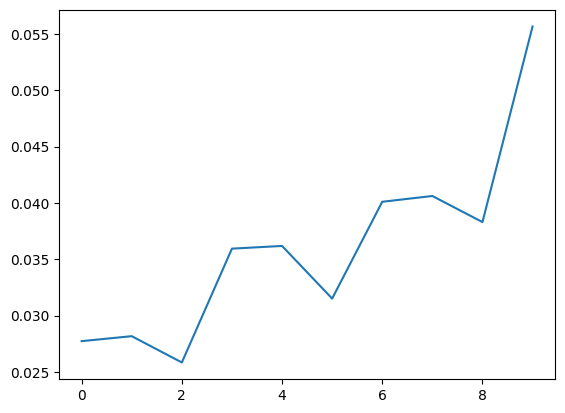

In [10]:
G_mse, G_var, sde_mse, sde_var = stats
plt.plot(np.arange(len(G_var)), np.array(G_var))

In [11]:
GAMMA = 0.5
G_ITERS = 10
D_ITERS = 1
f_ITERS = 3
MAX_STEPS = 10000

G mse: 0.22376705706119537
sde mse: 0.4854243993759155
G var: 0.08700981736183167
sde var: 0.3170730471611023


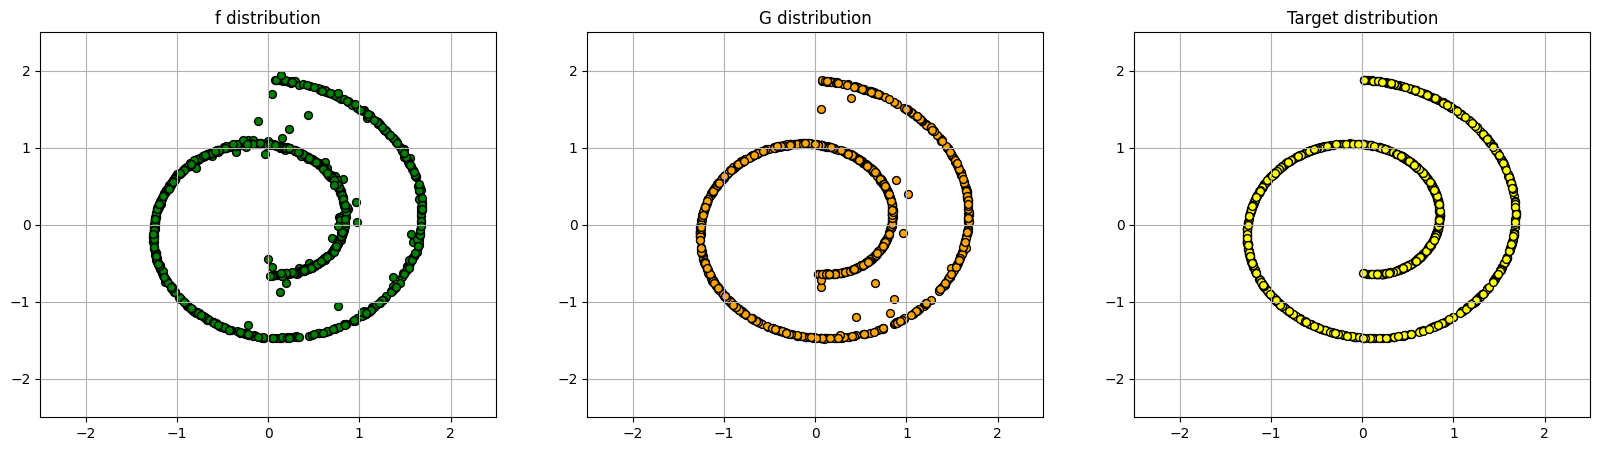

 95%|█████████▌| 9505/10000 [10:34<02:05,  3.96it/s]

1.0825262069702148 -4.622875213623047
0.8227947354316711 -4.678140640258789
0.9523425698280334 -4.628756046295166
1.19420325756073 -4.626504898071289


 95%|█████████▌| 9509/10000 [10:34<01:15,  6.46it/s]

1.1192015409469604 -4.671128273010254
0.9362490177154541 -4.711921691894531
0.7440913319587708 -4.684447765350342
0.8873341679573059 -4.684185028076172


 95%|█████████▌| 9513/10000 [10:34<00:52,  9.36it/s]

1.11362624168396 -4.693994522094727
1.0821592807769775 -4.7685227394104
1.0779045820236206 -4.730202674865723
1.0357954502105713 -4.69944953918457


 95%|█████████▌| 9517/10000 [10:34<00:41, 11.73it/s]

0.8277645707130432 -4.68900203704834
0.9286555647850037 -4.760998249053955
0.7693506479263306 -4.730473041534424
1.120158314704895 -4.818893909454346


 95%|█████████▌| 9521/10000 [10:35<00:34, 13.82it/s]

0.912018895149231 -4.797909259796143
0.8657532334327698 -4.7818379402160645
1.0592365264892578 -4.788498401641846
0.8184314966201782 -4.799439907073975


 95%|█████████▌| 9525/10000 [10:35<00:31, 15.16it/s]

1.0271649360656738 -4.802240371704102
0.8530518412590027 -4.834768295288086
0.857215166091919 -4.809394836425781
0.8747912049293518 -4.844345569610596


 95%|█████████▌| 9529/10000 [10:35<00:29, 15.87it/s]

0.735203742980957 -4.83743143081665
0.7398883700370789 -4.852075576782227
1.0296030044555664 -4.8302741050720215
0.9480013847351074 -4.805181980133057


 95%|█████████▌| 9533/10000 [10:35<00:28, 16.26it/s]

0.8072624206542969 -4.815586090087891
0.9860641956329346 -4.7887372970581055
0.9991886615753174 -4.746935844421387
1.0111756324768066 -4.724860668182373


 95%|█████████▌| 9537/10000 [10:36<00:28, 16.52it/s]

0.845982015132904 -4.690243721008301
0.9482276439666748 -4.706771373748779
0.837489902973175 -4.672667980194092
0.7005009651184082 -4.598302364349365


 95%|█████████▌| 9541/10000 [10:36<00:27, 16.49it/s]

1.0659252405166626 -4.6254987716674805
1.0693405866622925 -4.576032638549805
0.8510963916778564 -4.658201217651367
0.8371161818504333 -4.619685649871826


 95%|█████████▌| 9545/10000 [10:36<00:27, 16.47it/s]

0.8684022426605225 -4.575334548950195
0.8590012788772583 -4.558376312255859
1.106442928314209 -4.474841594696045
1.2024080753326416 -4.572729587554932


 95%|█████████▌| 9549/10000 [10:36<00:28, 16.01it/s]

0.8943889141082764 -4.518975734710693
1.0729670524597168 -4.506588459014893
0.7854133248329163 -4.466958999633789
0.7842315435409546 -4.514471054077148


 96%|█████████▌| 9553/10000 [10:37<00:27, 16.24it/s]

0.9254797101020813 -4.499222755432129
1.0094952583312988 -4.524718761444092
1.0679209232330322 -4.451913833618164
0.9706626534461975 -4.419904708862305


 96%|█████████▌| 9557/10000 [10:37<00:26, 16.43it/s]

0.9244977235794067 -4.4677886962890625
0.7497005462646484 -4.493256092071533
0.8344249129295349 -4.591049671173096
1.0317341089248657 -4.514584064483643


 96%|█████████▌| 9561/10000 [10:37<00:26, 16.44it/s]

0.7615236043930054 -4.494369029998779
0.7289968132972717 -4.583125114440918
0.7795764803886414 -4.576591968536377
0.9048382043838501 -4.621403694152832


 96%|█████████▌| 9565/10000 [10:37<00:26, 16.59it/s]

0.8150085806846619 -4.595505237579346
0.7768131494522095 -4.618707656860352
0.6934130191802979 -4.656875133514404
0.900352954864502 -4.764816761016846


 96%|█████████▌| 9569/10000 [10:37<00:26, 16.52it/s]

0.9732234477996826 -4.705669403076172
1.110364556312561 -4.731844902038574
0.762718915939331 -4.732627868652344
1.102816104888916 -4.732301712036133


 96%|█████████▌| 9573/10000 [10:38<00:25, 16.58it/s]

1.0462498664855957 -4.810054779052734
1.156429648399353 -4.8027472496032715
0.9517852067947388 -4.81320333480835
0.8116218447685242 -4.875368595123291


 96%|█████████▌| 9577/10000 [10:38<00:25, 16.62it/s]

0.9577131271362305 -4.816432952880859
0.9449697732925415 -4.848681449890137
1.1021901369094849 -4.873523235321045
0.8528014421463013 -4.840204238891602


 96%|█████████▌| 9581/10000 [10:38<00:25, 16.63it/s]

0.6990681886672974 -4.8669023513793945
0.9123507142066956 -4.905277252197266
0.7937425374984741 -4.847374439239502
0.7121618986129761 -4.908400535583496


 96%|█████████▌| 9585/10000 [10:38<00:25, 16.14it/s]

0.8735433220863342 -4.864442348480225
0.8184682130813599 -4.927569389343262
0.930332362651825 -4.907558441162109
1.043930172920227 -4.931591033935547


 96%|█████████▌| 9589/10000 [10:39<00:24, 16.52it/s]

1.0340375900268555 -4.8792643547058105
0.8517740368843079 -4.914762020111084
0.692430317401886 -4.853229522705078
0.8977641463279724 -4.911416053771973


 96%|█████████▌| 9593/10000 [10:39<00:24, 16.56it/s]

0.8327291011810303 -4.92388916015625
0.8796992897987366 -4.898678779602051
0.899681568145752 -4.921292304992676
0.6990422606468201 -4.843399524688721


 96%|█████████▌| 9597/10000 [10:39<00:24, 16.57it/s]

0.9371416568756104 -4.85161828994751
0.9975683689117432 -4.874467849731445
0.9486960768699646 -4.856014251708984
1.0944843292236328 -4.806673526763916


 96%|█████████▌| 9601/10000 [10:39<00:24, 16.48it/s]

0.8318387866020203 -4.835580825805664
0.8099921941757202 -4.805718898773193
1.005620002746582 -4.771226406097412
0.5665006041526794 -4.745518684387207


 96%|█████████▌| 9605/10000 [10:40<00:23, 16.51it/s]

0.6947525143623352 -4.73727560043335
1.0499565601348877 -4.788567543029785
0.9494830369949341 -4.733985424041748
0.9339454174041748 -4.7053985595703125


 96%|█████████▌| 9609/10000 [10:40<00:23, 16.54it/s]

0.9974909424781799 -4.675290107727051
0.748660147190094 -4.687004089355469
1.002814769744873 -4.658216953277588
0.8471421003341675 -4.653317928314209


 96%|█████████▌| 9613/10000 [10:40<00:23, 16.53it/s]

0.7388768196105957 -4.6469526290893555
0.8868884444236755 -4.652626991271973
0.9671642780303955 -4.639786243438721
0.9815523028373718 -4.59527063369751


 96%|█████████▌| 9617/10000 [10:40<00:23, 16.63it/s]

0.8982694149017334 -4.595499038696289
0.6794607043266296 -4.633311748504639
1.169797420501709 -4.609577178955078
1.0306533575057983 -4.600490093231201


 96%|█████████▌| 9621/10000 [10:41<00:23, 15.92it/s]

0.6650691032409668 -4.597448825836182
1.0485678911209106 -4.598073482513428
0.6223868131637573 -4.576407432556152
1.0709210634231567 -4.6103949546813965


 96%|█████████▋| 9625/10000 [10:41<00:22, 16.39it/s]

0.7347675561904907 -4.667577266693115
0.6244329214096069 -4.623410224914551
0.9455175399780273 -4.649243354797363
0.950928270816803 -4.698720455169678


 96%|█████████▋| 9629/10000 [10:41<00:22, 16.51it/s]

0.9344415664672852 -4.6347784996032715
1.0242468118667603 -4.625373363494873
0.774522602558136 -4.638698577880859
0.838173508644104 -4.635978698730469


 96%|█████████▋| 9633/10000 [10:41<00:22, 16.53it/s]

0.8455686569213867 -4.6616902351379395
0.9876187443733215 -4.625814437866211
0.847996175289154 -4.640006065368652
0.8002400398254395 -4.612358093261719


 96%|█████████▋| 9637/10000 [10:42<00:21, 16.66it/s]

0.9416666030883789 -4.579621315002441
0.6552854776382446 -4.5958733558654785
0.991678774356842 -4.623082160949707
0.8720912337303162 -4.587570667266846


 96%|█████████▋| 9641/10000 [10:42<00:21, 16.70it/s]

0.9022861123085022 -4.589964866638184
0.8879396915435791 -4.617661476135254
0.8599351644515991 -4.548640727996826
0.9023548364639282 -4.577089309692383


 96%|█████████▋| 9645/10000 [10:42<00:21, 16.72it/s]

0.7301937341690063 -4.524643898010254
0.9313250184059143 -4.568695545196533
1.1490793228149414 -4.546464920043945
1.1278823614120483 -4.572000980377197


 96%|█████████▋| 9649/10000 [10:42<00:22, 15.95it/s]

0.8876087069511414 -4.614295482635498
0.8950881958007812 -4.604681015014648
1.0344889163970947 -4.576836109161377
0.8290598392486572 -4.542706489562988


 97%|█████████▋| 9653/10000 [10:43<00:21, 16.39it/s]

0.8554765582084656 -4.6162190437316895
0.894639253616333 -4.595390319824219
0.9066749811172485 -4.6141357421875
0.9232384562492371 -4.648744106292725


 97%|█████████▋| 9657/10000 [10:43<00:20, 16.35it/s]

0.9995785355567932 -4.613797664642334
0.9896180629730225 -4.689090251922607
1.1008902788162231 -4.608291149139404
0.8762897253036499 -4.630142688751221


 97%|█████████▋| 9661/10000 [10:43<00:20, 16.58it/s]

0.8304071426391602 -4.612025737762451
1.1186274290084839 -4.644256114959717
1.045123815536499 -4.6120195388793945
0.8997576832771301 -4.597280502319336


 97%|█████████▋| 9665/10000 [10:43<00:20, 16.73it/s]

0.9851095676422119 -4.601684093475342
1.0776832103729248 -4.576517105102539
1.0856781005859375 -4.5381927490234375
0.9789491891860962 -4.516765117645264


 97%|█████████▋| 9669/10000 [10:44<00:19, 16.95it/s]

0.9060201644897461 -4.46730375289917
0.8019958138465881 -4.501854419708252
0.8373587131500244 -4.418941497802734
0.8024657964706421 -4.401244640350342


 97%|█████████▋| 9673/10000 [10:44<00:19, 16.68it/s]

0.9966381788253784 -4.323292255401611
0.8303170204162598 -4.338938236236572
1.0384831428527832 -4.3044819831848145
0.8926023840904236 -4.280431747436523


 97%|█████████▋| 9677/10000 [10:44<00:19, 16.62it/s]

0.8367272615432739 -4.285445690155029
0.8582703471183777 -4.308135986328125
0.9037668108940125 -4.289336681365967
1.1438968181610107 -4.284451484680176


 97%|█████████▋| 9681/10000 [10:44<00:19, 16.49it/s]

0.8097245097160339 -4.313817501068115
0.7629232406616211 -4.303365230560303
0.8965360522270203 -4.3817973136901855
1.043707013130188 -4.448779582977295


 97%|█████████▋| 9683/10000 [10:44<00:19, 16.29it/s]

0.7707806825637817 -4.409726619720459
1.003694772720337 -4.514377117156982
0.887535035610199 -4.558346748352051


 97%|█████████▋| 9687/10000 [10:45<00:19, 15.95it/s]

0.8890325427055359 -4.566533088684082
0.7754468321800232 -4.548102855682373
0.955186665058136 -4.5920023918151855
0.7514519095420837 -4.6204447746276855


 97%|█████████▋| 9691/10000 [10:45<00:18, 16.32it/s]

0.5570160150527954 -4.64026403427124
1.2339259386062622 -4.671520709991455
1.1660124063491821 -4.69658899307251
0.6684610843658447 -4.709950923919678


 97%|█████████▋| 9695/10000 [10:45<00:18, 16.52it/s]

0.9188798069953918 -4.74965238571167
0.9287845492362976 -4.7660112380981445
0.7535449266433716 -4.732918739318848
0.9738962054252625 -4.7811198234558105


 97%|█████████▋| 9699/10000 [10:45<00:17, 16.73it/s]

0.8167646527290344 -4.788585186004639
0.7475146651268005 -4.810192584991455
1.0386781692504883 -4.869939804077148
1.0402060747146606 -4.877557754516602


 97%|█████████▋| 9703/10000 [10:46<00:17, 16.55it/s]

0.9543614387512207 -4.876893520355225
1.0560342073440552 -4.862821578979492
0.9688255190849304 -4.826119422912598
1.0260674953460693 -4.872893333435059


 97%|█████████▋| 9707/10000 [10:46<00:17, 16.65it/s]

0.8943018913269043 -4.854756832122803
1.1342027187347412 -4.917562961578369
1.0276564359664917 -4.930917263031006
0.6987548470497131 -4.950958251953125


 97%|█████████▋| 9711/10000 [10:46<00:17, 16.68it/s]

0.9329939484596252 -4.967967987060547
0.9480207562446594 -4.873335361480713
0.9243754148483276 -4.932640552520752
1.0217584371566772 -4.959550380706787


 97%|█████████▋| 9715/10000 [10:46<00:17, 16.66it/s]

0.9591115117073059 -4.991130352020264
1.3606853485107422 -4.997941970825195
0.8920136094093323 -5.006255149841309
0.9087175130844116 -5.02158260345459


 97%|█████████▋| 9719/10000 [10:47<00:17, 15.89it/s]

1.012880563735962 -5.057792663574219
0.8672598600387573 -5.0313615798950195
0.7288156747817993 -4.991137981414795
0.8282204270362854 -4.999190807342529


 97%|█████████▋| 9723/10000 [10:47<00:17, 16.25it/s]

1.0328537225723267 -5.035058975219727
0.779584527015686 -5.02390193939209
0.8615328669548035 -4.993039131164551
0.8882763981819153 -5.033107757568359


 97%|█████████▋| 9727/10000 [10:47<00:16, 16.53it/s]

1.0378745794296265 -4.997614860534668
0.8791739344596863 -4.995464324951172
0.7282667756080627 -5.004237651824951
0.7371243834495544 -5.027267932891846


 97%|█████████▋| 9731/10000 [10:47<00:16, 16.69it/s]

0.8126044273376465 -4.999265670776367
0.7253314256668091 -4.985025405883789
0.9150019884109497 -4.972725868225098
0.9576329588890076 -4.96628999710083


 97%|█████████▋| 9735/10000 [10:48<00:15, 16.79it/s]

0.6384840607643127 -4.990748405456543
0.8010498285293579 -5.022332668304443
1.0412101745605469 -4.974567890167236
0.876453697681427 -4.881760597229004


 97%|█████████▋| 9739/10000 [10:48<00:15, 16.82it/s]

0.9811057448387146 -4.938377857208252
0.8268091082572937 -4.96039342880249
0.8145407438278198 -4.971816062927246
0.878019392490387 -4.912275314331055


 97%|█████████▋| 9743/10000 [10:48<00:15, 16.79it/s]

0.7726683020591736 -4.968448638916016
0.8239374756813049 -4.912079811096191
0.846376895904541 -4.925549507141113
0.8496503233909607 -4.8874359130859375


 97%|█████████▋| 9747/10000 [10:48<00:15, 16.36it/s]

0.8296899795532227 -4.902187347412109
0.9270886182785034 -4.833280563354492
0.8187142014503479 -4.849257946014404
0.7874478697776794 -4.854123115539551


 98%|█████████▊| 9751/10000 [10:49<00:15, 16.46it/s]

0.778525710105896 -4.82819128036499
0.8341525793075562 -4.809389114379883
1.0939593315124512 -4.893237113952637
0.9590610861778259 -4.779220104217529


 98%|█████████▊| 9755/10000 [10:49<00:15, 16.09it/s]

0.8764593601226807 -4.8057122230529785
0.903538703918457 -4.729609489440918
1.020265817642212 -4.745711803436279
0.8948973417282104 -4.701907634735107


 98%|█████████▊| 9759/10000 [10:49<00:14, 16.27it/s]

0.8854693174362183 -4.719524383544922
0.9919619560241699 -4.660194396972656
0.944647490978241 -4.674556255340576
0.759660542011261 -4.683547019958496


 98%|█████████▊| 9763/10000 [10:49<00:14, 16.58it/s]

0.9543977975845337 -4.646816730499268
0.864153265953064 -4.637477397918701
0.9410365223884583 -4.614525318145752
0.914275586605072 -4.598355770111084


 98%|█████████▊| 9767/10000 [10:50<00:14, 16.54it/s]

1.101753830909729 -4.594743251800537
0.9604783654212952 -4.604244232177734
0.8086299896240234 -4.6271843910217285
0.7777719497680664 -4.5876145362854


 98%|█████████▊| 9771/10000 [10:50<00:13, 16.60it/s]

0.8709714412689209 -4.549625396728516
0.7745035290718079 -4.515254497528076
0.72618168592453 -4.506901741027832
0.9126365184783936 -4.489697456359863


 98%|█████████▊| 9775/10000 [10:50<00:13, 16.62it/s]

0.8688012957572937 -4.515186786651611
0.8577933311462402 -4.486363887786865
0.900363564491272 -4.498992443084717
0.7703234553337097 -4.434912204742432


 98%|█████████▊| 9779/10000 [10:50<00:13, 16.58it/s]

1.0266332626342773 -4.3954362869262695
0.9393144845962524 -4.404008865356445
1.0028531551361084 -4.340605735778809
0.726693868637085 -4.435863971710205


 98%|█████████▊| 9783/10000 [10:50<00:13, 16.43it/s]

1.2012821435928345 -4.380322456359863
0.786948561668396 -4.367635726928711
0.7480602860450745 -4.397689342498779
0.7353411912918091 -4.352149486541748


 98%|█████████▊| 9787/10000 [10:51<00:13, 15.69it/s]

0.8236348628997803 -4.346108436584473
0.8096475601196289 -4.385980606079102
1.0467931032180786 -4.342071056365967
0.856895923614502 -4.282113552093506


 98%|█████████▊| 9791/10000 [10:51<00:12, 16.15it/s]

0.9243097901344299 -4.2500410079956055
0.7016779780387878 -4.17678165435791
0.9144197702407837 -4.150404453277588
0.8528320789337158 -4.289564609527588


 98%|█████████▊| 9795/10000 [10:51<00:12, 16.46it/s]

0.8572334051132202 -4.172168731689453
0.8741194605827332 -4.16817569732666
0.9769411087036133 -4.033908843994141
0.9189397692680359 -4.184787273406982


 98%|█████████▊| 9799/10000 [10:51<00:12, 16.61it/s]

1.1056994199752808 -4.157336235046387
0.9416099786758423 -4.142895221710205
0.876115083694458 -4.161284446716309
0.8923293352127075 -4.140295028686523


 98%|█████████▊| 9803/10000 [10:52<00:12, 16.15it/s]

0.8724106550216675 -4.209064483642578
0.7354185581207275 -4.164310932159424
0.9424319863319397 -4.317318439483643
0.8133013844490051 -4.3417229652404785


 98%|█████████▊| 9807/10000 [10:52<00:11, 16.44it/s]

0.9706576466560364 -4.4272637367248535
0.8034011721611023 -4.415750026702881
0.9122083187103271 -4.488554954528809
0.8183629512786865 -4.52916955947876


 98%|█████████▊| 9811/10000 [10:52<00:11, 16.32it/s]

0.9112585186958313 -4.57181978225708
0.9950688481330872 -4.567309856414795
0.7693710923194885 -4.612489700317383
0.8114078044891357 -4.645844459533691


 98%|█████████▊| 9815/10000 [10:52<00:11, 16.48it/s]

0.7107614278793335 -4.686164855957031
0.9438753724098206 -4.749295234680176
0.9085025787353516 -4.748034477233887
0.8430229425430298 -4.790520668029785


 98%|█████████▊| 9819/10000 [10:53<00:10, 16.47it/s]

1.172622799873352 -4.786138534545898
1.0219498872756958 -4.750116348266602
1.0901821851730347 -4.820887565612793
0.918083131313324 -4.814098358154297


 98%|█████████▊| 9823/10000 [10:53<00:11, 15.95it/s]

1.0561612844467163 -4.792388916015625
1.2449629306793213 -4.801665306091309
0.9475070834159851 -4.830678939819336
0.9654191136360168 -4.85875129699707


 98%|█████████▊| 9827/10000 [10:53<00:10, 16.28it/s]

0.8110822439193726 -4.826338291168213
1.2213054895401 -4.845036029815674
0.8700866103172302 -4.8079915046691895
0.8329769968986511 -4.831190586090088


 98%|█████████▊| 9831/10000 [10:53<00:10, 16.48it/s]

0.9634358882904053 -4.771104335784912
0.8042823672294617 -4.867347717285156
0.7424669861793518 -4.83418083190918
0.9729219675064087 -4.867912292480469


 98%|█████████▊| 9835/10000 [10:54<00:09, 16.58it/s]

1.0735687017440796 -4.824958801269531
0.9142158031463623 -4.841720104217529
1.2100958824157715 -4.826955318450928
1.0211206674575806 -4.838029384613037


 98%|█████████▊| 9839/10000 [10:54<00:09, 16.62it/s]

0.986915647983551 -4.852841854095459
1.0042117834091187 -4.8270392417907715
0.8886150121688843 -4.86873722076416
0.6830567717552185 -4.835308074951172


 98%|█████████▊| 9843/10000 [10:54<00:09, 16.56it/s]

0.753429114818573 -4.863039970397949
0.6267425417900085 -4.878363609313965
0.8633968830108643 -4.903468132019043
1.0998969078063965 -4.859278678894043


 98%|█████████▊| 9847/10000 [10:54<00:09, 16.56it/s]

0.9007740020751953 -4.886344909667969
0.7588278651237488 -4.853141784667969
0.8732749819755554 -4.895287036895752
0.882361114025116 -4.881572723388672


 99%|█████████▊| 9851/10000 [10:55<00:09, 16.16it/s]

0.8618656396865845 -4.861591815948486
1.1501845121383667 -4.8916826248168945
0.7419582009315491 -4.8703694343566895
0.7570512294769287 -4.89455509185791


 99%|█████████▊| 9855/10000 [10:55<00:09, 15.64it/s]

0.7927793264389038 -4.93223237991333
1.1556650400161743 -4.938629627227783
0.9682597517967224 -4.887483596801758
0.7982417345046997 -4.920657634735107


 99%|█████████▊| 9859/10000 [10:55<00:08, 15.98it/s]

0.8336747288703918 -4.935436248779297
0.8620368242263794 -4.8975419998168945
1.1390196084976196 -4.875033378601074
0.8301618695259094 -4.9161906242370605


 99%|█████████▊| 9863/10000 [10:55<00:08, 16.14it/s]

0.8377342224121094 -4.917593002319336
0.7748260498046875 -4.9553608894348145
0.6132819056510925 -4.966485500335693
1.0156241655349731 -4.9134202003479


 99%|█████████▊| 9867/10000 [10:56<00:08, 16.46it/s]

0.9341349601745605 -4.924668788909912
0.996330201625824 -4.891274452209473
0.8018031120300293 -4.871539115905762
0.9469621777534485 -4.880184650421143


 99%|█████████▊| 9871/10000 [10:56<00:07, 16.50it/s]

0.7077817320823669 -4.932285308837891
0.8247969150543213 -4.909426212310791
0.8548992276191711 -4.917333126068115
0.846402108669281 -4.848900318145752


 99%|█████████▉| 9875/10000 [10:56<00:07, 16.60it/s]

0.8765078783035278 -4.858889102935791
0.9595043659210205 -4.864436626434326
0.7484107613563538 -4.884565830230713
0.975189208984375 -4.824116230010986


 99%|█████████▉| 9879/10000 [10:56<00:07, 16.69it/s]

0.9655482172966003 -4.830626010894775
0.8264541029930115 -4.800549507141113
0.9367759227752686 -4.853158473968506
0.7509941458702087 -4.828192710876465


 99%|█████████▉| 9883/10000 [10:57<00:07, 16.56it/s]

1.1089234352111816 -4.828374862670898
0.829797625541687 -4.829897880554199
0.7593847513198853 -4.8371734619140625
0.8373401761054993 -4.800450325012207


 99%|█████████▉| 9887/10000 [10:57<00:07, 15.64it/s]

0.9363303780555725 -4.7894768714904785
0.8615212440490723 -4.749083995819092
0.9645766019821167 -4.752622604370117


 99%|█████████▉| 9891/10000 [10:57<00:06, 16.19it/s]

0.8750201463699341 -4.762963771820068
0.8850359916687012 -4.716456890106201
0.7201487421989441 -4.730742454528809
0.8025557994842529 -4.712182998657227


 99%|█████████▉| 9895/10000 [10:57<00:06, 16.06it/s]

1.1829737424850464 -4.6548027992248535
0.9026069045066833 -4.611591815948486
0.8603641390800476 -4.53765869140625
0.9199944734573364 -4.599431991577148


 99%|█████████▉| 9899/10000 [10:58<00:06, 16.39it/s]

0.9330329298973083 -4.541384220123291
0.9468233585357666 -4.5624918937683105
0.8736113905906677 -4.525811195373535
0.9516698122024536 -4.429789066314697


 99%|█████████▉| 9903/10000 [10:58<00:05, 16.38it/s]

1.0183113813400269 -4.4388298988342285
0.9035999178886414 -4.422579765319824
0.7216691970825195 -4.388150691986084
0.881616473197937 -4.284036159515381


 99%|█████████▉| 9907/10000 [10:58<00:05, 16.50it/s]

0.9900909662246704 -4.295627117156982
0.9732360243797302 -4.247711658477783
0.6854321956634521 -4.189734935760498
0.7853737473487854 -4.273950576782227


 99%|█████████▉| 9911/10000 [10:58<00:05, 16.46it/s]

0.8280606269836426 -4.260632038116455
0.8108969926834106 -4.279935359954834
1.0750747919082642 -4.311856269836426
1.0868500471115112 -4.212497234344482


 99%|█████████▉| 9915/10000 [10:59<00:05, 16.45it/s]

0.7233781218528748 -4.258276462554932
0.9174021482467651 -4.197731018066406
0.8645947575569153 -4.234199523925781
1.274641752243042 -4.139979362487793


 99%|█████████▉| 9919/10000 [10:59<00:04, 16.56it/s]

0.9931871891021729 -4.2337646484375
0.8655673265457153 -4.211912631988525
0.9033657312393188 -4.078548908233643
0.8562291860580444 -4.110133647918701


 99%|█████████▉| 9923/10000 [10:59<00:04, 15.91it/s]

0.9316680431365967 -4.144904613494873
0.7554286122322083 -4.11893367767334
1.0478054285049438 -4.1556243896484375
0.8739917278289795 -4.237086296081543


 99%|█████████▉| 9927/10000 [10:59<00:04, 16.09it/s]

0.7774039506912231 -4.2126240730285645
0.8483967185020447 -4.329921245574951
0.945723831653595 -4.2585906982421875
0.69683837890625 -4.388328552246094


 99%|█████████▉| 9931/10000 [11:00<00:04, 16.34it/s]

0.7718456983566284 -4.478886127471924
1.086719274520874 -4.435679912567139
0.901675820350647 -4.444009780883789
0.9688512086868286 -4.613727569580078


 99%|█████████▉| 9935/10000 [11:00<00:03, 16.37it/s]

0.7003315091133118 -4.565032005310059
0.7415857911109924 -4.644155502319336
0.8276083469390869 -4.699323654174805
1.091508388519287 -4.858123302459717


 99%|█████████▉| 9939/10000 [11:00<00:03, 15.86it/s]

0.9264030456542969 -4.839056968688965
1.0460699796676636 -4.843585014343262
1.0539393424987793 -4.8909125328063965
0.9976606965065002 -4.886432647705078


 99%|█████████▉| 9943/10000 [11:00<00:03, 16.22it/s]

0.9472317695617676 -5.008607387542725
1.0026566982269287 -4.925836086273193
1.073205590248108 -4.999061584472656
0.8003783822059631 -4.9792609214782715


 99%|█████████▉| 9947/10000 [11:01<00:03, 16.43it/s]

0.842253565788269 -4.985709190368652
0.8238130211830139 -5.00633430480957
0.827745795249939 -4.976642608642578
0.9557175636291504 -4.99221134185791


100%|█████████▉| 9951/10000 [11:01<00:03, 16.27it/s]

1.0641144514083862 -4.961991310119629
0.8655768632888794 -4.95210075378418
0.8001419901847839 -4.939153671264648
1.0658252239227295 -4.876824378967285


100%|█████████▉| 9955/10000 [11:01<00:02, 15.95it/s]

0.7426743507385254 -4.8883376121521
1.2423139810562134 -4.829647541046143
0.7949761748313904 -4.8080878257751465
0.9734142422676086 -4.896500110626221


100%|█████████▉| 9959/10000 [11:01<00:02, 16.24it/s]

1.12002432346344 -4.854628562927246
0.7696000933647156 -4.798259735107422
1.041625738143921 -4.87498664855957
0.7261185646057129 -4.82012939453125


100%|█████████▉| 9963/10000 [11:02<00:02, 16.50it/s]

1.0071406364440918 -4.779576301574707
0.7992122769355774 -4.713951587677002
1.0250787734985352 -4.752627372741699
0.819993793964386 -4.685925006866455


100%|█████████▉| 9967/10000 [11:02<00:01, 16.65it/s]

0.6867356896400452 -4.6999945640563965
0.7154080271720886 -4.6953959465026855
0.9056476354598999 -4.7971696853637695
0.9604824781417847 -4.720441818237305


100%|█████████▉| 9971/10000 [11:02<00:01, 16.71it/s]

0.8451674580574036 -4.704617977142334
0.6997000575065613 -4.6571879386901855
0.837209165096283 -4.75049352645874
0.8677423000335693 -4.636666297912598


100%|█████████▉| 9975/10000 [11:02<00:01, 16.76it/s]

0.9397902488708496 -4.668194770812988
0.8705463409423828 -4.701930999755859
1.2676724195480347 -4.69235372543335
0.7242858409881592 -4.788956165313721


100%|█████████▉| 9979/10000 [11:02<00:01, 16.83it/s]

0.9065700173377991 -4.677890777587891
0.8810218572616577 -4.666081428527832
1.1472077369689941 -4.747518062591553
0.8344551920890808 -4.755112648010254


100%|█████████▉| 9983/10000 [11:03<00:01, 16.80it/s]

0.9984615445137024 -4.7386155128479
1.0013554096221924 -4.6823859214782715
0.8292114734649658 -4.738190650939941
1.0753850936889648 -4.721485137939453


100%|█████████▉| 9985/10000 [11:03<00:00, 15.48it/s]

0.8105736374855042 -4.751480579376221
0.893743097782135 -4.644999027252197
0.9139758944511414 -4.734356880187988


100%|█████████▉| 9989/10000 [11:03<00:00, 15.96it/s]

0.7787905335426331 -4.717421054840088
1.0047216415405273 -4.797500133514404
1.0632613897323608 -4.779397487640381
0.8473643660545349 -4.768568515777588


100%|█████████▉| 9993/10000 [11:03<00:00, 15.98it/s]

1.0152575969696045 -4.673238754272461
1.0227022171020508 -4.7939453125
0.6912020444869995 -4.761702537536621
0.8983855247497559 -4.730749130249023


100%|█████████▉| 9997/10000 [11:04<00:00, 16.22it/s]

1.0210108757019043 -4.751999378204346
0.9639411568641663 -4.718998432159424
0.8286828994750977 -4.738893032073975
0.8172252774238586 -4.824042320251465


100%|██████████| 10000/10000 [11:04<00:00, 15.05it/s]

0.8129947185516357 -4.833036422729492
0.768309473991394 -4.874172210693359


In [12]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=1000)

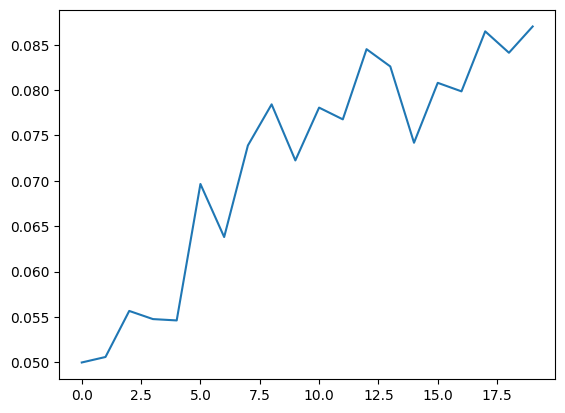

In [13]:
G_mse, G_var, sde_mse, sde_var = stats
plt.plot(np.arange(len(G_var)), np.array(G_var))

G mse: 0.244419127702713
sde mse: 0.5024710893630981
G var: 0.09249541163444519
sde var: 0.3165779411792755


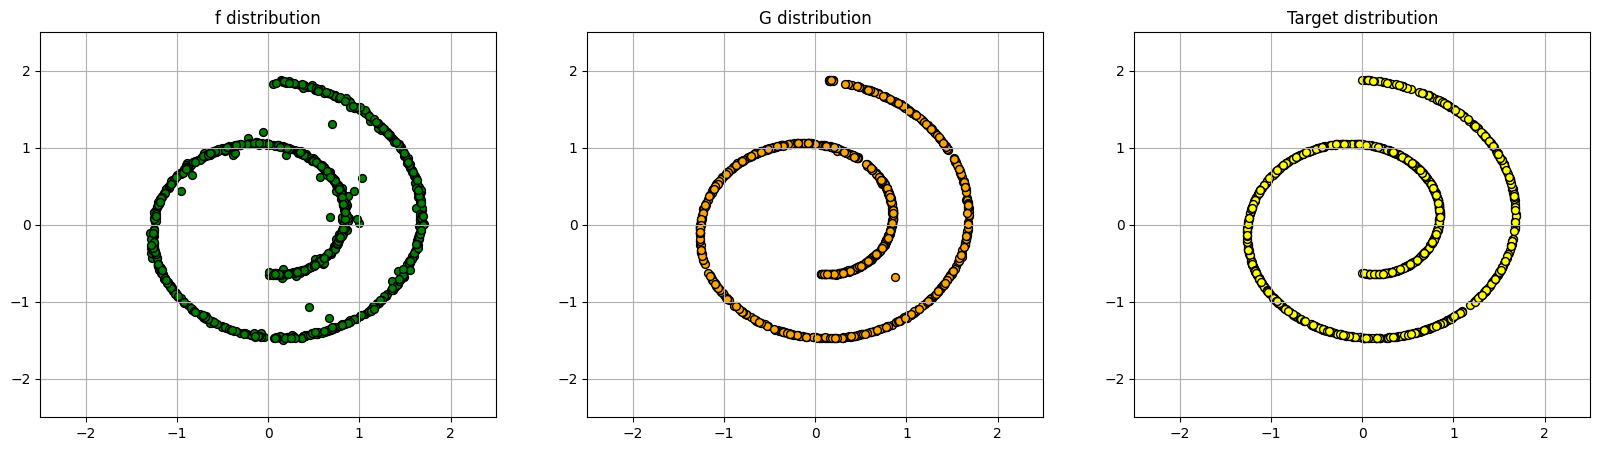

 95%|█████████▌| 9505/10000 [10:37<02:09,  3.82it/s]

1.0798231363296509 -6.703268051147461
0.7704203128814697 -6.657559394836426
1.1936880350112915 -6.6540985107421875
0.9811488389968872 -6.600148677825928


 95%|█████████▌| 9509/10000 [10:37<01:18,  6.27it/s]

0.8385691046714783 -6.636786937713623
0.9323471188545227 -6.719395637512207
0.8553479313850403 -6.715226650238037
0.9292542934417725 -6.793195724487305


 95%|█████████▌| 9513/10000 [10:37<00:52,  9.25it/s]

1.2720643281936646 -6.8405961990356445
0.9418396353721619 -6.822786808013916
0.775266170501709 -6.792158126831055
0.7331352829933167 -6.862757205963135


 95%|█████████▌| 9517/10000 [10:37<00:40, 12.04it/s]

0.9010176062583923 -6.784181118011475
1.0583313703536987 -6.839512348175049
1.1461859941482544 -6.842132091522217
0.9492166638374329 -6.81278657913208


 95%|█████████▌| 9521/10000 [10:38<00:34, 14.02it/s]

0.9770601391792297 -6.793629169464111
0.7480087280273438 -6.833863735198975
0.8939749598503113 -6.812573432922363
0.6405272483825684 -6.80706787109375


 95%|█████████▌| 9525/10000 [10:38<00:31, 14.85it/s]

1.005691647529602 -6.881255149841309
0.9844828248023987 -6.912156581878662
0.9745667576789856 -6.887886047363281
1.0052804946899414 -6.8438825607299805


 95%|█████████▌| 9529/10000 [10:38<00:30, 15.22it/s]

0.8759354948997498 -6.856943130493164
1.007817268371582 -6.826053142547607
0.9023937582969666 -6.909911632537842
0.892778754234314 -6.860960483551025


 95%|█████████▌| 9533/10000 [10:39<00:30, 15.21it/s]

1.2226752042770386 -6.878559112548828
1.2883983850479126 -6.843198776245117
0.9031408429145813 -6.85001802444458
1.0211379528045654 -6.860716342926025


 95%|█████████▌| 9537/10000 [10:39<00:29, 15.82it/s]

1.0573649406433105 -6.898722171783447
1.00067138671875 -6.881696701049805
1.022092580795288 -6.908956050872803
0.9255246520042419 -6.904068946838379


 95%|█████████▌| 9541/10000 [10:39<00:28, 16.19it/s]

1.2923225164413452 -6.9339518547058105
0.9218403100967407 -6.896735191345215
0.9223712682723999 -6.858833312988281
0.9786139726638794 -6.91301155090332


 95%|█████████▌| 9545/10000 [10:39<00:27, 16.33it/s]

0.9532454013824463 -6.817846298217773
0.9966726303100586 -6.870788097381592
0.836767315864563 -6.784677028656006
0.8895505666732788 -6.8094635009765625


 95%|█████████▌| 9549/10000 [10:39<00:27, 16.41it/s]

0.9761126041412354 -6.867163181304932
0.8320601582527161 -6.822870254516602
1.0448052883148193 -6.874566555023193
0.888942539691925 -6.808094024658203


 96%|█████████▌| 9553/10000 [10:40<00:27, 16.44it/s]

0.8788559436798096 -6.823311805725098
1.0810418128967285 -6.784580230712891
0.6413516998291016 -6.796382904052734
0.8812010884284973 -6.748340606689453


 96%|█████████▌| 9557/10000 [10:40<00:26, 16.45it/s]

0.8052480816841125 -6.744473934173584
0.8365771174430847 -6.751477241516113
0.9530285000801086 -6.784947395324707
0.9344034790992737 -6.781030654907227


 96%|█████████▌| 9561/10000 [10:40<00:26, 16.47it/s]

0.9048121571540833 -6.78074836730957
0.6862221360206604 -6.734359264373779
0.8112414479255676 -6.705112457275391
0.9329379796981812 -6.7478156089782715


 96%|█████████▌| 9565/10000 [10:40<00:26, 16.56it/s]

0.9618165493011475 -6.657803535461426
0.7715333700180054 -6.7077178955078125
0.983606219291687 -6.7368011474609375
0.8538897037506104 -6.672550678253174


 96%|█████████▌| 9569/10000 [10:41<00:26, 16.05it/s]

0.8669929504394531 -6.68635368347168
0.9036954641342163 -6.624279022216797
0.8145121335983276 -6.625980854034424
0.8131576776504517 -6.723813056945801


 96%|█████████▌| 9573/10000 [10:41<00:25, 16.55it/s]

0.8560926914215088 -6.693814754486084
0.7607274651527405 -6.685614109039307
1.0382767915725708 -6.656728267669678
0.9991620779037476 -6.5888471603393555


 96%|█████████▌| 9577/10000 [10:41<00:25, 16.76it/s]

0.8947635889053345 -6.630934238433838
0.799560546875 -6.638320446014404
0.7805256843566895 -6.660553932189941
0.8736887574195862 -6.677943706512451


 96%|█████████▌| 9581/10000 [10:41<00:25, 16.57it/s]

0.8387804627418518 -6.621011257171631
0.7763498425483704 -6.668693542480469
0.8414945006370544 -6.667914390563965
1.021309733390808 -6.618581295013428


 96%|█████████▌| 9585/10000 [10:42<00:25, 16.38it/s]

0.9770899415016174 -6.631775856018066
1.2099331617355347 -6.601362228393555
0.7271459698677063 -6.583986759185791
0.7397916913032532 -6.571707248687744


 96%|█████████▌| 9589/10000 [10:42<00:24, 16.46it/s]

0.9825253486633301 -6.565123558044434
0.9367916584014893 -6.519837379455566
0.8740341663360596 -6.537773609161377
0.9211747050285339 -6.5236663818359375


 96%|█████████▌| 9593/10000 [10:42<00:24, 16.39it/s]

1.2238287925720215 -6.573038578033447
0.8019625544548035 -6.542811870574951
0.8557160496711731 -6.524819850921631
0.9745638370513916 -6.489597797393799


 96%|█████████▌| 9597/10000 [10:42<00:24, 16.23it/s]

1.2822442054748535 -6.455106258392334
0.756219208240509 -6.520217418670654
1.0310828685760498 -6.4172210693359375
0.8908492922782898 -6.324654579162598


 96%|█████████▌| 9601/10000 [10:43<00:24, 16.09it/s]

0.7989220023155212 -6.246762275695801
0.7339922785758972 -6.323934555053711
0.9433462619781494 -6.419164657592773
0.9848085045814514 -6.359043121337891


 96%|█████████▌| 9605/10000 [10:43<00:26, 15.13it/s]

1.0278054475784302 -6.38438606262207
0.9284627437591553 -6.372626781463623
0.8452537059783936 -6.42601203918457
1.223915457725525 -6.430074691772461


 96%|█████████▌| 9609/10000 [10:43<00:25, 15.46it/s]

0.8749430179595947 -6.416372299194336
0.8463334441184998 -6.45108699798584
0.9354802966117859 -6.496757507324219
0.9952753186225891 -6.400604724884033


 96%|█████████▌| 9613/10000 [10:43<00:24, 15.62it/s]

1.0291085243225098 -6.43988561630249
0.8465388417243958 -6.496214389801025
0.7785040140151978 -6.556467533111572
0.7685175538063049 -6.492940425872803


 96%|█████████▌| 9617/10000 [10:44<00:24, 15.91it/s]

0.7058181762695312 -6.47864294052124
0.9300249814987183 -6.478229999542236
0.8121246695518494 -6.497520923614502
0.9927388429641724 -6.492193698883057


 96%|█████████▌| 9621/10000 [10:44<00:23, 16.33it/s]

0.8620070219039917 -6.5414719581604
0.8375136852264404 -6.470306873321533
0.9659168720245361 -6.5007219314575195
0.9397010803222656 -6.471485614776611


 96%|█████████▋| 9625/10000 [10:44<00:22, 16.42it/s]

0.7607941031455994 -6.486704349517822
0.8878761529922485 -6.460938453674316
0.9225888252258301 -6.399082660675049
0.9479864835739136 -6.4581499099731445


 96%|█████████▋| 9629/10000 [10:44<00:22, 16.28it/s]

0.8713796734809875 -6.415790557861328
0.9244397878646851 -6.41263484954834
0.7380899786949158 -6.416715621948242
0.831454873085022 -6.400861740112305


 96%|█████████▋| 9633/10000 [10:45<00:22, 16.36it/s]

0.9295253157615662 -6.3736114501953125
0.896221935749054 -6.3773651123046875
0.8370967507362366 -6.368092060089111
1.0245232582092285 -6.395918369293213


 96%|█████████▋| 9637/10000 [10:45<00:22, 16.38it/s]

0.7467404007911682 -6.429838180541992
1.0268157720565796 -6.39280891418457
0.8870158195495605 -6.429599761962891
0.848871648311615 -6.432069778442383


 96%|█████████▋| 9641/10000 [10:45<00:23, 15.58it/s]

0.8422664403915405 -6.459544658660889
1.1561673879623413 -6.440621852874756
0.9839611053466797 -6.469718933105469
0.9462748765945435 -6.461091041564941


 96%|█████████▋| 9645/10000 [10:45<00:22, 15.64it/s]

0.8306783437728882 -6.444913387298584
0.6124498248100281 -6.474885940551758
0.771543562412262 -6.473695755004883
1.1438082456588745 -6.439300537109375


 96%|█████████▋| 9649/10000 [10:46<00:21, 16.07it/s]

0.8651438355445862 -6.510526180267334
0.7510587573051453 -6.518161773681641
1.0792467594146729 -6.457182884216309
0.8454999327659607 -6.468653678894043


 97%|█████████▋| 9653/10000 [10:46<00:21, 16.30it/s]

0.5801734328269958 -6.4873528480529785
1.1197004318237305 -6.509793281555176
0.8973953723907471 -6.520923137664795
0.7845287322998047 -6.4628753662109375


 97%|█████████▋| 9657/10000 [10:46<00:20, 16.41it/s]

0.8128839135169983 -6.469738483428955
0.9996417760848999 -6.529217720031738
0.9945440292358398 -6.389276504516602
0.8638108968734741 -6.428349494934082


 97%|█████████▋| 9661/10000 [10:46<00:21, 15.82it/s]

1.049712896347046 -6.41237735748291
1.0154075622558594 -6.50831937789917
1.0829598903656006 -6.421736717224121
0.9985894560813904 -6.470137119293213


 97%|█████████▋| 9665/10000 [10:47<00:20, 16.04it/s]

1.056064248085022 -6.4162092208862305
1.0147615671157837 -6.368083477020264
0.9184132218360901 -6.388911724090576
0.9240263104438782 -6.360177040100098


 97%|█████████▋| 9667/10000 [10:47<00:20, 16.00it/s]

0.8898193836212158 -6.345241546630859
1.0833210945129395 -6.272790431976318
1.0365568399429321 -6.20405387878418


 97%|█████████▋| 9671/10000 [10:47<00:21, 15.52it/s]

0.9587666392326355 -6.198159217834473
0.8485739827156067 -6.128815174102783
1.1329319477081299 -6.1593732833862305
0.8975079655647278 -6.061252117156982


 97%|█████████▋| 9675/10000 [10:47<00:20, 15.90it/s]

0.8866414427757263 -6.0352864265441895
0.7838552594184875 -6.023360729217529
0.7995871901512146 -6.081430912017822
1.0271204710006714 -5.980662822723389


 97%|█████████▋| 9679/10000 [10:48<00:19, 16.08it/s]

0.8079701662063599 -5.886279106140137
0.9337184429168701 -6.053634166717529
0.9563886523246765 -6.064978122711182
0.8529355525970459 -6.0082879066467285


 97%|█████████▋| 9683/10000 [10:48<00:19, 16.43it/s]

0.9426771998405457 -6.104166030883789
0.9998083710670471 -6.182042121887207
1.008301854133606 -6.157740592956543
1.1271198987960815 -6.228453159332275


 97%|█████████▋| 9687/10000 [10:48<00:19, 16.44it/s]

0.887708842754364 -6.248434066772461
1.0030276775360107 -6.239563941955566
0.6854230165481567 -6.271109580993652
1.118252158164978 -6.2802414894104


 97%|█████████▋| 9691/10000 [10:48<00:19, 16.12it/s]

0.7873386144638062 -6.319065570831299
0.793722927570343 -6.271919250488281
0.802738606929779 -6.239262104034424
0.7332131862640381 -6.211073875427246


 97%|█████████▋| 9695/10000 [10:49<00:18, 16.19it/s]

0.9308566451072693 -6.268876552581787
0.9620635509490967 -6.192841053009033
0.8686853051185608 -6.234714508056641
0.755872368812561 -6.228977680206299


 97%|█████████▋| 9699/10000 [10:49<00:18, 16.31it/s]

0.8707588315010071 -6.202488899230957
0.9588575959205627 -6.214735507965088
0.8753063678741455 -6.223076343536377
1.1195595264434814 -6.171028137207031


 97%|█████████▋| 9703/10000 [10:49<00:18, 15.84it/s]

0.7425030469894409 -6.148027420043945
1.060853362083435 -6.1173200607299805
0.8149289488792419 -6.059373378753662
0.9065860509872437 -6.064002990722656


 97%|█████████▋| 9707/10000 [10:49<00:18, 15.80it/s]

0.7884274125099182 -6.014551162719727
0.7750005722045898 -6.019391059875488
0.8941798210144043 -6.027113437652588
1.1100233793258667 -5.976790428161621


 97%|█████████▋| 9711/10000 [10:50<00:18, 15.72it/s]

1.182641863822937 -6.013467311859131
0.8603386282920837 -6.050286293029785
0.9289354085922241 -6.019385814666748
0.7725642323493958 -6.1070990562438965


 97%|█████████▋| 9715/10000 [10:50<00:18, 15.81it/s]

0.8493911623954773 -6.12180757522583
0.6871580481529236 -6.144408702850342
1.044286847114563 -6.143136024475098
0.9298949241638184 -6.163961410522461


 97%|█████████▋| 9719/10000 [10:50<00:18, 15.36it/s]

0.972155749797821 -6.1870832443237305
0.8886985182762146 -6.192963123321533
0.8804352283477783 -6.215826511383057
1.000327229499817 -6.237186431884766


 97%|█████████▋| 9723/10000 [10:50<00:17, 15.39it/s]

1.0403817892074585 -6.234932899475098
0.79471355676651 -6.273677825927734
1.0002689361572266 -6.240650653839111
0.9573017358779907 -6.256152629852295


 97%|█████████▋| 9727/10000 [10:51<00:17, 15.77it/s]

0.6657282710075378 -6.271080017089844
0.946495532989502 -6.25132942199707
1.0611196756362915 -6.243849754333496
0.8692370057106018 -6.286036014556885


 97%|█████████▋| 9731/10000 [10:51<00:16, 16.05it/s]

0.8923968076705933 -6.296555042266846
0.8349766731262207 -6.243066787719727
1.0155616998672485 -6.313471794128418
0.8898024559020996 -6.343600749969482


 97%|█████████▋| 9735/10000 [10:51<00:16, 15.81it/s]

0.9187152981758118 -6.3156819343566895
0.7565081715583801 -6.292456150054932
0.9825464487075806 -6.334766864776611
0.8576384782791138 -6.329503059387207


 97%|█████████▋| 9739/10000 [10:51<00:16, 15.96it/s]

0.7973149418830872 -6.369399547576904
0.9850106239318848 -6.338140964508057
1.038693904876709 -6.30863094329834
0.6985604763031006 -6.310946464538574


 97%|█████████▋| 9743/10000 [10:52<00:16, 16.01it/s]

0.8329407572746277 -6.345753192901611
1.0060076713562012 -6.368966579437256
0.8394509553909302 -6.353684902191162
0.6260033845901489 -6.301374435424805


 97%|█████████▋| 9747/10000 [10:52<00:15, 16.31it/s]

0.76463383436203 -6.35685396194458
1.0751111507415771 -6.402997970581055
1.1453907489776611 -6.357382297515869
0.9094304442405701 -6.310155391693115


 98%|█████████▊| 9751/10000 [10:52<00:15, 16.51it/s]

1.114723563194275 -6.371344089508057
1.1585206985473633 -6.322185039520264
0.7700842618942261 -6.346197605133057
0.6853746175765991 -6.361608982086182


 98%|█████████▊| 9755/10000 [10:52<00:14, 16.62it/s]

0.9439339637756348 -6.388443946838379
0.9327057003974915 -6.294707775115967
0.854173481464386 -6.304112911224365
0.7283526062965393 -6.287070274353027


 98%|█████████▊| 9759/10000 [10:53<00:14, 16.81it/s]

1.1130309104919434 -6.296919822692871
1.126416802406311 -6.238046646118164
0.7897568345069885 -6.297019004821777
0.8183929920196533 -6.233098030090332


 98%|█████████▊| 9763/10000 [10:53<00:15, 15.76it/s]

0.7624518871307373 -6.257031440734863
1.3290903568267822 -6.256982803344727
0.7258904576301575 -6.22139835357666


 98%|█████████▊| 9767/10000 [10:53<00:14, 16.21it/s]

0.9289770126342773 -6.246995449066162
0.8877606987953186 -6.217123508453369
1.1877106428146362 -6.193169116973877
0.779780924320221 -6.1213812828063965


 98%|█████████▊| 9771/10000 [10:53<00:14, 16.28it/s]

0.848194420337677 -6.131984710693359
0.9945526123046875 -6.189307689666748
0.6589373350143433 -6.14762020111084
0.9125528931617737 -6.143595218658447


 98%|█████████▊| 9775/10000 [10:54<00:13, 16.18it/s]

0.7184096574783325 -6.054289817810059
0.9328824877738953 -6.0531134605407715
0.6408830881118774 -6.043994426727295
0.8444953560829163 -5.969130516052246


 98%|█████████▊| 9779/10000 [10:54<00:13, 16.44it/s]

1.0896836519241333 -6.040563583374023
0.8021543622016907 -5.956939697265625
1.0663508176803589 -5.9299702644348145
1.027925729751587 -5.983135223388672


 98%|█████████▊| 9783/10000 [10:54<00:13, 16.36it/s]

0.9159132242202759 -6.067156791687012
0.8288458585739136 -6.180657386779785
0.8883976936340332 -6.23507833480835
0.5589736104011536 -6.300817489624023


 98%|█████████▊| 9787/10000 [10:54<00:12, 16.59it/s]

1.0882235765457153 -6.320367336273193
0.9043242335319519 -6.324127197265625
1.0750938653945923 -6.471623420715332
0.9768743515014648 -6.416363716125488


 98%|█████████▊| 9791/10000 [10:55<00:12, 16.66it/s]

0.8116706609725952 -6.520659446716309
1.0063939094543457 -6.466336250305176
1.028367042541504 -6.556398868560791
0.6971554756164551 -6.446508884429932


 98%|█████████▊| 9795/10000 [10:55<00:12, 16.15it/s]

0.8715826869010925 -6.538390636444092
0.7807211875915527 -6.5231781005859375
1.0454298257827759 -6.544836044311523
0.984000563621521 -6.644939422607422


 98%|█████████▊| 9799/10000 [10:55<00:12, 15.67it/s]

0.7271801233291626 -6.671885967254639
0.9417374730110168 -6.613885879516602
0.9312233924865723 -6.643016815185547
0.5936033725738525 -6.590158462524414


 98%|█████████▊| 9803/10000 [10:55<00:12, 16.11it/s]

0.8824923634529114 -6.626128196716309
1.1107981204986572 -6.639471054077148
1.0201176404953003 -6.646378993988037
0.7798805832862854 -6.625714302062988


 98%|█████████▊| 9807/10000 [10:56<00:11, 16.38it/s]

0.9323190450668335 -6.6056809425354
0.6945034265518188 -6.69875431060791
1.0225905179977417 -6.5822834968566895
0.9889061450958252 -6.7079291343688965


 98%|█████████▊| 9811/10000 [10:56<00:11, 16.61it/s]

1.1530954837799072 -6.692480564117432
1.0277233123779297 -6.660712242126465
0.844456136226654 -6.682323455810547
0.9992376565933228 -6.681251525878906


 98%|█████████▊| 9815/10000 [10:56<00:11, 16.78it/s]

0.9355677366256714 -6.672972202301025
0.8541499972343445 -6.636379241943359
0.8277244567871094 -6.680189609527588
1.1214600801467896 -6.616069793701172


 98%|█████████▊| 9819/10000 [10:56<00:10, 16.80it/s]

0.9191969633102417 -6.596837997436523
0.800961971282959 -6.597386360168457
0.8478885889053345 -6.596614360809326
0.7140302658081055 -6.549064636230469


 98%|█████████▊| 9823/10000 [10:56<00:10, 16.96it/s]

1.1550796031951904 -6.51088809967041
0.8093178272247314 -6.594651699066162
0.8927919268608093 -6.569293022155762
0.7796290516853333 -6.558830261230469


 98%|█████████▊| 9827/10000 [10:57<00:10, 16.98it/s]

0.9421142935752869 -6.552052974700928
0.8000720739364624 -6.608319282531738
0.7582941055297852 -6.548868656158447
0.8824533224105835 -6.583750247955322


 98%|█████████▊| 9829/10000 [10:57<00:10, 16.92it/s]

0.9166467189788818 -6.544355869293213
1.0315879583358765 -6.586381435394287
0.9229291081428528 -6.492422103881836
0.8689692616462708 -6.423088073730469


 98%|█████████▊| 9835/10000 [10:57<00:10, 16.43it/s]

0.791782021522522 -6.436614513397217
0.7525585889816284 -6.449300765991211
0.7453796863555908 -6.424767971038818
1.0787549018859863 -6.426007270812988


 98%|█████████▊| 9839/10000 [10:57<00:09, 16.26it/s]

1.0176138877868652 -6.390085220336914
0.9619870185852051 -6.413603782653809
0.9985501766204834 -6.286777496337891
0.6626920700073242 -6.3880615234375


 98%|█████████▊| 9843/10000 [10:58<00:09, 16.29it/s]

0.8111291527748108 -6.294555187225342
0.6106352806091309 -6.273351669311523
0.8197968006134033 -6.282451629638672
0.6717201471328735 -6.266545295715332


 98%|█████████▊| 9847/10000 [10:58<00:09, 16.57it/s]

0.7348686456680298 -6.269111633300781
0.7605045437812805 -6.247314929962158
0.9706864356994629 -6.227365970611572
0.9318618774414062 -6.192696571350098


 99%|█████████▊| 9851/10000 [10:58<00:09, 16.32it/s]

0.6827046871185303 -6.239698886871338
1.1359164714813232 -6.224249362945557
0.9840703010559082 -6.254127025604248
1.0913108587265015 -6.286124229431152


 99%|█████████▊| 9855/10000 [10:58<00:08, 16.12it/s]

1.0716496706008911 -6.3108320236206055
1.1385223865509033 -6.401861190795898
0.8874245882034302 -6.380098342895508
0.854782223701477 -6.381063938140869


 99%|█████████▊| 9859/10000 [10:59<00:08, 16.16it/s]

0.6809486746788025 -6.405350685119629
0.8478968143463135 -6.4221062660217285
0.8888653516769409 -6.379608154296875
0.7777136564254761 -6.455480575561523


 99%|█████████▊| 9861/10000 [10:59<00:08, 16.18it/s]

0.935512125492096 -6.500326633453369
0.7965734004974365 -6.478987216949463
0.9380468130111694 -6.465470790863037


 99%|█████████▊| 9865/10000 [10:59<00:08, 15.26it/s]

0.9026978015899658 -6.5052876472473145
1.2740063667297363 -6.53376579284668
0.8290990591049194 -6.526185989379883
0.9903251528739929 -6.495040416717529


 99%|█████████▊| 9869/10000 [10:59<00:08, 15.78it/s]

0.7636318802833557 -6.525209903717041
0.9143103957176208 -6.535231590270996
1.1339329481124878 -6.486067771911621
0.8849053978919983 -6.532742023468018


 99%|█████████▊| 9873/10000 [11:00<00:07, 16.06it/s]

0.8859546780586243 -6.533594608306885
1.1034009456634521 -6.5370378494262695
0.9703782200813293 -6.578099250793457
0.8410135507583618 -6.605164527893066


 99%|█████████▉| 9877/10000 [11:00<00:07, 16.45it/s]

0.7706711888313293 -6.58967924118042
0.9183751344680786 -6.526965141296387
0.8546916842460632 -6.536702632904053
1.015184760093689 -6.567922592163086


 99%|█████████▉| 9881/10000 [11:00<00:07, 16.66it/s]

0.8761084079742432 -6.5595502853393555
0.7441225051879883 -6.601308822631836
1.0923823118209839 -6.590090274810791
1.0017706155776978 -6.548149585723877


 99%|█████████▉| 9885/10000 [11:00<00:06, 16.79it/s]

0.9131004810333252 -6.604877948760986
0.8267834186553955 -6.624321460723877
0.5997171401977539 -6.588191509246826
0.97337406873703 -6.571657657623291


 99%|█████████▉| 9889/10000 [11:01<00:06, 16.84it/s]

1.0424931049346924 -6.599043846130371
1.052473545074463 -6.6267924308776855
0.82555091381073 -6.590798377990723
0.8143758177757263 -6.530877113342285


 99%|█████████▉| 9893/10000 [11:01<00:06, 16.85it/s]

1.103636384010315 -6.527182102203369
1.0762187242507935 -6.545701026916504
0.7919570803642273 -6.530833721160889
1.077663779258728 -6.532664775848389


 99%|█████████▉| 9897/10000 [11:01<00:06, 15.99it/s]

0.8394668102264404 -6.4896039962768555
0.7103936672210693 -6.448354244232178
1.0787583589553833 -6.539875030517578
0.8620566725730896 -6.569445610046387


 99%|█████████▉| 9901/10000 [11:01<00:06, 16.32it/s]

0.730196475982666 -6.454342842102051
1.0857099294662476 -6.469435691833496
1.0684865713119507 -6.451014041900635
1.0737699270248413 -6.490950584411621


 99%|█████████▉| 9905/10000 [11:02<00:05, 16.21it/s]

0.9249502420425415 -6.442334175109863
0.9363029599189758 -6.418302059173584
0.7465617060661316 -6.373641490936279
0.8012609481811523 -6.379124164581299


 99%|█████████▉| 9909/10000 [11:02<00:05, 16.40it/s]

0.8052818179130554 -6.359220027923584
1.0478168725967407 -6.373080253601074
0.9207172393798828 -6.351929187774658
0.9859868288040161 -6.324267864227295


 99%|█████████▉| 9913/10000 [11:02<00:05, 16.41it/s]

0.9649436473846436 -6.314187049865723
0.9019300937652588 -6.296443939208984
0.6810830235481262 -6.250399589538574
0.8286334872245789 -6.224615573883057


 99%|█████████▉| 9917/10000 [11:02<00:05, 16.35it/s]

0.8391470909118652 -6.191396713256836
0.6919906735420227 -6.169191837310791
0.8775437474250793 -6.169671058654785
0.9564228057861328 -6.199370384216309


 99%|█████████▉| 9921/10000 [11:03<00:04, 15.90it/s]

0.7953915596008301 -6.175647258758545
0.9777082204818726 -6.118441104888916
0.7744719386100769 -6.166750431060791
0.9795829653739929 -6.159648418426514


 99%|█████████▉| 9925/10000 [11:03<00:04, 16.35it/s]

0.9139907956123352 -6.173684120178223
0.9659307599067688 -6.138296127319336
0.7712503671646118 -6.163877010345459
0.8184245824813843 -6.134888648986816


 99%|█████████▉| 9929/10000 [11:03<00:04, 15.94it/s]

1.0716854333877563 -6.1663689613342285
0.8871749639511108 -6.145923137664795
1.0143076181411743 -6.18872594833374
0.8203684091567993 -6.145857810974121


 99%|█████████▉| 9933/10000 [11:03<00:04, 16.06it/s]

0.8718563914299011 -6.198723793029785
0.801086962223053 -6.163170337677002
0.9623698592185974 -6.182193756103516
0.7946156859397888 -6.246564865112305


 99%|█████████▉| 9937/10000 [11:03<00:03, 16.29it/s]

0.8855821490287781 -6.234405517578125
0.815439760684967 -6.23959493637085
0.8013094663619995 -6.27509880065918
0.8000695109367371 -6.237739562988281


 99%|█████████▉| 9941/10000 [11:04<00:03, 16.44it/s]

0.6752608418464661 -6.262718200683594
1.0772757530212402 -6.276731967926025
0.8334183096885681 -6.2967529296875
0.7811253070831299 -6.282240390777588


 99%|█████████▉| 9945/10000 [11:04<00:03, 16.58it/s]

0.7032225728034973 -6.3277482986450195
1.1509093046188354 -6.316844940185547
0.8179788589477539 -6.295502662658691
0.8999477028846741 -6.322702407836914


 99%|█████████▉| 9949/10000 [11:04<00:03, 16.53it/s]

0.8784570097923279 -6.35803747177124
1.0192853212356567 -6.32176399230957
1.1095255613327026 -6.331498146057129
0.8809205889701843 -6.384182929992676


100%|█████████▉| 9953/10000 [11:04<00:02, 16.56it/s]

0.953106164932251 -6.3134446144104
0.6993791460990906 -6.293295383453369
0.6533079743385315 -6.240198135375977
0.8134347200393677 -6.321385383605957


100%|█████████▉| 9957/10000 [11:05<00:02, 16.51it/s]

0.9266971349716187 -6.331799030303955
0.8080195784568787 -6.32742977142334
0.5324957966804504 -6.293747425079346
0.7786245346069336 -6.345551013946533


100%|█████████▉| 9961/10000 [11:05<00:02, 15.89it/s]

0.8821481466293335 -6.378817081451416
0.8355690240859985 -6.3391947746276855
0.9984530806541443 -6.350416660308838
0.6923375129699707 -6.342484474182129


100%|█████████▉| 9965/10000 [11:05<00:02, 16.40it/s]

0.8801175951957703 -6.3902716636657715
1.0436599254608154 -6.325423717498779
0.9167259335517883 -6.3614182472229
0.8766071200370789 -6.334168434143066


100%|█████████▉| 9969/10000 [11:05<00:01, 16.71it/s]

1.0246703624725342 -6.254967212677002
0.9585638642311096 -6.245761871337891
0.95819491147995 -6.301943778991699
1.1553446054458618 -6.269582271575928


100%|█████████▉| 9973/10000 [11:06<00:01, 16.59it/s]

0.9350305199623108 -6.303211212158203
0.9093933701515198 -6.247764587402344
0.7580116391181946 -6.256968975067139
0.8891451954841614 -6.264880180358887


100%|█████████▉| 9977/10000 [11:06<00:01, 16.22it/s]

0.8373966217041016 -6.256614685058594
0.9519696235656738 -6.2220001220703125
0.7921561598777771 -6.27773380279541
1.1199874877929688 -6.316300392150879


100%|█████████▉| 9981/10000 [11:06<00:01, 16.15it/s]

0.6765627264976501 -6.274568557739258
0.7813761234283447 -6.240906715393066
0.8532623052597046 -6.230166435241699
0.9101746082305908 -6.207866191864014


100%|█████████▉| 9985/10000 [11:06<00:00, 16.37it/s]

0.9470018148422241 -6.25890588760376
0.7927826642990112 -6.207120418548584
0.9413620829582214 -6.2436723709106445
0.878780722618103 -6.2635345458984375


100%|█████████▉| 9989/10000 [11:07<00:00, 16.38it/s]

0.9842698574066162 -6.251250743865967
0.8741612434387207 -6.1850199699401855
0.7210649251937866 -6.216109752655029
0.874822735786438 -6.201603889465332


100%|█████████▉| 9993/10000 [11:07<00:00, 15.73it/s]

1.0829399824142456 -6.2099738121032715
0.7749093174934387 -6.210516929626465
0.8291645646095276 -6.237511157989502
0.7221285104751587 -6.320705413818359


100%|█████████▉| 9997/10000 [11:07<00:00, 16.05it/s]

1.275864601135254 -6.297558784484863
1.0187678337097168 -6.397765159606934
0.6942123174667358 -6.362768650054932
0.9569920301437378 -6.346010684967041


100%|██████████| 10000/10000 [11:07<00:00, 14.97it/s]

0.8892670273780823 -6.421432018280029
1.1546680927276611 -6.372629165649414


In [14]:
stats = trainENOT(X_sampler, Y_sampler, G, G_opt, D, D_opt, sde, sde_opt, plot_n_samples=1000)

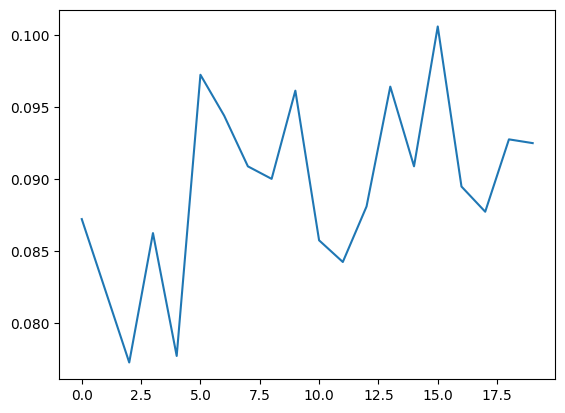

In [15]:
G_mse, G_var, sde_mse, sde_var = stats
plt.plot(np.arange(len(G_var)), np.array(G_var))